# Notebook to replicate the findings reported in [Recording gene expression order in DNA by CRISPR addition of retron barcodes (Bhattarai-Kline et. al 2022, Nature)](https://www.nature.com/articles/s41586-022-04994-6)

### Preface

We have adapted the scripts pertaining to our publication (Bhattarai-Kline et. al 2022, Nature), available on our [GitHub](https://github.com/Shipman-Lab/Spacer-Seq), into this Jupyter notebook. This notebook serves as a self-contained, interactive walkthrough of the deep sequencing data generated during our experiments. The notebook requires `Jupyter-notebook` to be installed; the rest of the dependencies are handled internally within the notebook. Note that the analysis pipeline is meant to be run on a Unix-like operating system; nonetheless, it can be adapted to run on Windows-based OSs with minimal changes to the notebook, which are pointed out herein.

### Overview of the analysis pipeline

After quality-based read trimming, the first part of the analysis consists in extracting new spacers found in the sequenced CRISPR arrays, and storing both the new spacer sequences and the sequence of the read containing them. These reads and spacers are binned according to their characteristics, including the number of new spacers per read.       
      
Next, the order of the spacers in each newly-expanded CRISPR array is determined, as well as whether these new spacers are derived from either of the barcoded retron noncoding RNAs (henceforth referred to as $A$ and $B$ spacers) or not (henceforth referred to as $N$ spacers, likely genome- or plasmid-derived).     
      
For a CRISPR array to be informative in terms of inferring the order transcriptional events, it must meet three criteria: (a) the array should contain at least two new spacers, (b) at least one of the spacers should contain a barcoded retron-derived spacer, and (c) at least two spacers must have different identities. Explicitly, the number of $A \to B \to \text{Leader}$, $A \to N \to \text{Leader}$, …, etc. CRISPR arrays are counted and used for the calculation of ordering scores, discussed in more detail below.      
      
Following the count of each spacer ordering possibility, we calculate three ordering scores, which describe and help us infer the ordering of transcriptional events. These scores make an assumption about the biology: that $N$ spacers are acquired at a constant rate during the course of the recording experiment. Moreover, this analysis is designed to reconstruct a transcriptional history into two epochs, one early and one late. Further subdivision of the temporal signal would require a substantially more complicated analysis than is provided here.    
     
In cases such as ours where two promoters are under study, the CRISPR arrays are analyzed for order based on three scores, each $\in [-1,1]$: (1) the $A/B$ score, (2) the $A/N$ score, and (3) the $B/N$ score.    
1. **A/B score.** The A/B score determines both the order of and magnitude of temporal separation between the transcriptional events evidenced by the acquisition of spacers $A$ and $B$. Positive scores suggest that transcriptional event $A$ occurred before $B$ and thus more $B$ spacers are found in the Leader-proximal position relative to the number of $A$ spacers; on the other hand, negative scores suggest the opposite, namely that event $B$ occurred before $A$. The magnitude of the score represents the temporal separation between $A$ or $B$, or how much the transcriptional activity between $A$ or $B$ overlaps in time. The more their activity overlaps in time, the closer to zero this score will be.     
2. **A/N score.** The $A/N$ score determines how the timing of $A$ is expressed in comparison to the constant signal $N$, for the duration of the recording experiment. It takes into account the relative frequencies of Leader-distal vs. Leader-adjacent $A$-expanded arrays: a positive score suggests that $A$ is strongly expressed in the first epoch rather than the second, and conversely for a negative score.     
3. **B/N score.** The same interpretations of the $A/N$ score applies here, except in relation to $B$ rather than $A$. However, by definition, $B/N$ takes into account the relative frequencies of Leader-adjacent vs. Leader-proximal $B$-expanded arrays: positive scores suggest that $B$ occurred in the second epoch rather than the first, and conversely for a negative score.
     
Fig. 3b-e in Lear et. al 2022, Nat Protocols provides hypothetical examples of different transcriptional activity for two promoters across two epochs and what scores might be expected in such cases. See also Box 3 in Lear et. al 2022, Nat Protocols for more information about the exact mathematical calculations and interpretation of a given composite score.

### Getting started

Before downloading and attempting to run this notebook, make sure you have `jupyterlab` or a related flavour of ipynb handlers installed. Then, clone this repo into your desired path, and `cd` into it.

### Dependencies

These are the dependencies that the notebook uses. These should all be available through Anaconda's channels, and can be installed by running the cell below.
      
* Biopython (if not, install: `pip install biopython`)
* fuzzysearch (if not, install: `pip install fuzzysearch`)
* sickle (or sickle-trim -- if not, install: `conda install sickle-trim`; `conda install -c bioconda sickle-trim`)
* seaborn (if not, install: `pip install seaborn`)
* numpy (if not, install: `pip install numpy`)
* pandas (if not, install: `pip install pandas`)
* matplotlib (if not, install: `python -m pip install -U matplotlib`)
* multiprocess (if not, install: `pip install multiprocess`)

#### Check dependencies -- install them if need be

In [3]:
import pkg_resources, sys
from pkg_resources import DistributionNotFound, VersionConflict

dependencies = [
    'biopython',
    'sickle-trim',
    'seaborn',
    'numpy',
    'matplotlib',
    'fuzzysearch',
    'pandas',
    'multiprocess']



for d in dependencies:
    print (d)
    try:
        pkg_resources.require(d)
    except Exception as e:
        print (e)
        print ("installing dependency: ", d)
        ! conda install --yes --prefix {sys.prefix} $d


biopython
sickle-trim
The 'sickle-trim' distribution was not found and is required by the application
installing dependency:  sickle-trim
Solving environment: done

# All requested packages already installed.

seaborn
numpy
matplotlib
fuzzysearch
pandas
multiprocess


### Import packages / dependencies

In [243]:
import sys, os, glob, re, shutil, subprocess, itertools, multiprocessing
from collections import Counter, OrderedDict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fuzzysearch
from difflib import SequenceMatcher

from multiprocessing import Process, Manager
import multiprocess as mp

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord



plt.rcParams['pdf.fonttype'] = 42
pd.options.mode.chained_assignment = None  # default='warn'


### Load SRA run table
This dataframe contains metadata describing the sequencing files. You can find the file `SraRunTable.txt` [here](https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=2&WebEnv=MCID_62f154c3d722cf4f612873a7&o=acc_s%3Aa&s=SRR19211554,SRR19211555,SRR19211556,SRR19211557,SRR19211558,SRR19211559,SRR19211560,SRR19211561,SRR19211562,SRR19211563,SRR19211564,SRR19211565,SRR19211566,SRR19211567,SRR19211568,SRR19211569,SRR19211570,SRR19211571,SRR19211572,SRR19211574,SRR19211575,SRR19211576,SRR19211577,SRR19211578,SRR19211579,SRR19211581,SRR19211582,SRR19211583,SRR19211584,SRR19211585,SRR19211586,SRR19211587,SRR19211588,SRR19211590,SRR19211591,SRR19211592,SRR19211593,SRR19211594,SRR19211595,SRR19211596,SRR19211597,SRR19211598,SRR19211599,SRR19211601,SRR19211602,SRR19211603,SRR19211604,SRR19211605,SRR19211606,SRR19211607,SRR19211608,SRR19211609,SRR19211610,SRR19211611,SRR19211612,SRR19211613,SRR19211614,SRR19211616,SRR19211617,SRR19211618,SRR19211619,SRR19211620,SRR19211621,SRR19211622,SRR19211623,SRR19211624,SRR19211625,SRR19211627,SRR19211628,SRR19211629,SRR19211630,SRR19211632,SRR19211634,SRR19211635,SRR19211636,SRR19211637,SRR19211638,SRR19211639,SRR19211640,SRR19211641,SRR19211642,SRR19211643,SRR19211644,SRR19211645,SRR19211646,SRR19211647,SRR19211648,SRR19211649,SRR19211650,SRR19211652,SRR19211654,SRR19211655,SRR19211656,SRR19211657,SRR19211658,SRR19211659,SRR19211660,SRR19211661,SRR19211663,SRR19211664,SRR19211665,SRR19211666,SRR19211667,SRR19211668,SRR19211669,SRR19211671,SRR19211672,SRR19211674,SRR19211675,SRR19211676,SRR19211677,SRR19211678,SRR19211679,SRR19211681,SRR19211682,SRR19211683,SRR19211684,SRR19211685,SRR19211686,SRR19211687,SRR19211688,SRR19211689,SRR19211690,SRR19211691,SRR19211692,SRR19211693,SRR19211694,SRR19211695,SRR19211697,SRR19211698,SRR19211699,SRR19211700,SRR19211701,SRR19211702,SRR19211703,SRR19211704,SRR19211705,SRR19211706,SRR19211707,SRR19211708,SRR19211709,SRR19211710,SRR19211711,SRR19211712,SRR19211714,SRR19211715,SRR19211716,SRR19211718,SRR19211719,SRR19211720,SRR19211721,SRR19211722,SRR19211723,SRR19211724,SRR19211725,SRR19211726,SRR19211727,SRR19211728,SRR19211730,SRR19211731,SRR19211732,SRR19211733,SRR19211734,SRR19211735,SRR19211736,SRR19211737,SRR19211738,SRR19211739,SRR19211740,SRR19211741,SRR19211742,SRR19211743,SRR19211744,SRR19211745,SRR19211746,SRR19211747,SRR19211748,SRR19211749,SRR19211750,SRR19211751,SRR19211752,SRR19211753,SRR19211754,SRR19211755,SRR19211756,SRR19211757,SRR19211758,SRR19211759,SRR19211761,SRR19211762,SRR19211763,SRR19211764,SRR19211765,SRR19211766,SRR19211767,SRR19211769,SRR19211770,SRR19211771,SRR19211772,SRR19211773,SRR19211774,SRR19211775,SRR19211776,SRR19211777,SRR19211778,SRR19211780,SRR19211781,SRR19211782,SRR19211783,SRR19211784,SRR19211785,SRR19211786,SRR19211787,SRR19211788,SRR19211789,SRR19211790,SRR19211791,SRR19211792,SRR19211793,SRR19211794,SRR19211795,SRR19211796,SRR19211797,SRR19211798,SRR19211799,SRR19211800,SRR19211801,SRR19211803,SRR19211804,SRR19211805,SRR19211806,SRR19211807,SRR19211808,SRR19211809,SRR19211811,SRR19211812,SRR19211813,SRR19211814,SRR19211815,SRR19211817,SRR19211818,SRR19211819,SRR19211820,SRR19211821,SRR19211823,SRR19211824,SRR19211825,SRR19211826,SRR19211827,SRR19211828,SRR19211829,SRR19211832,SRR19211833,SRR19211834,SRR19211835,SRR19211836,SRR19211837,SRR19211838,SRR19211839,SRR19211840,SRR19211841,SRR19211842,SRR19211844,SRR19211845,SRR19211847,SRR19211849,SRR19211850,SRR19211851,SRR19211853,SRR19211854,SRR19211855,SRR19211856,SRR19211857,SRR19211858,SRR19211859,SRR19211860,SRR19211861,SRR19211863,SRR19211865,SRR19211867,SRR19211868,SRR19211573,SRR19211589,SRR19211633,SRR19211651,SRR19211670,SRR19211696,SRR19211729,SRR19211779,SRR19211848,SRR19211852,SRR19211600,SRR19211615,SRR19211626,SRR19211631,SRR19211653,SRR19211673,SRR19211680,SRR19211713,SRR19211717,SRR19211768,SRR19211802,SRR19211810,SRR19211816,SRR19211822,SRR19211830,SRR19211831,SRR19211843,SRR19211862,SRR19211864,SRR19211866,SRR19211580,SRR19211662,SRR19211760,SRR19211846), or download it off our GitHub.

In [244]:
df_files = pd.read_csv("SraRunTable.txt")#[["Figure", "Panel", "Condition", "Replicate", "Exact filename"]]
# df_files["Figure"]

#### In this notebook, we'll focus on re-creating Fig. 4L from Bhattarai-Kline et. al 2022, Nature

In [245]:
df_fig4 = df_files[(df_files["Figure"] == 4) & (df_files["panel"] == "l")]
df_fig4

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,BioSampleModel,Bytes,Center Name,Collection_date,...,panel,Platform,ReleaseDate,replicate,Sample Name,sample_type,section,SRA Study,strain,Also_present_in
117,SRR19211685,AMPLICON,246,61000238,PRJNA838025,SAMN28402444,"Microbe\, viral or environmental",34447900,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR5_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR5_rep6||ED_6b_PCR5_rep6
118,SRR19211686,AMPLICON,246,13623090,PRJNA838025,SAMN28402443,"Microbe\, viral or environmental",7334762,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR4_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR4_rep6||ED_6b_PCR4_rep6
120,SRR19211688,AMPLICON,246,18841740,PRJNA838025,SAMN28402442,"Microbe\, viral or environmental",10144811,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR3_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep6||ED_6b_PCR3_rep6
121,SRR19211689,AMPLICON,246,23466189,PRJNA838025,SAMN28402441,"Microbe\, viral or environmental",12585604,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR2_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR2_rep6||ED_6b_PCR2_rep6
122,SRR19211690,AMPLICON,246,10919197,PRJNA838025,SAMN28402440,"Microbe\, viral or environmental",5907360,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR1_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR1_rep6||ED_6b_PCR1_rep6
123,SRR19211691,AMPLICON,246,83581276,PRJNA838025,SAMN28402439,"Microbe\, viral or environmental",46420767,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR5_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR5_rep5||ED_6b_PCR5_rep5
124,SRR19211692,AMPLICON,246,16999434,PRJNA838025,SAMN28402438,"Microbe\, viral or environmental",8936264,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR4_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR4_rep5||ED_6b_PCR4_rep5
125,SRR19211693,AMPLICON,246,13551639,PRJNA838025,SAMN28402437,"Microbe\, viral or environmental",7116272,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR3_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep5||ED_6b_PCR3_rep5
126,SRR19211694,AMPLICON,246,14702023,PRJNA838025,SAMN28402436,"Microbe\, viral or environmental",7771401,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR2_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR2_rep5||ED_6b_PCR2_rep5
127,SRR19211695,AMPLICON,246,16777602,PRJNA838025,SAMN28402435,"Microbe\, viral or environmental",8825376,GLADSTONE INSTITUTES,2021-05,...,l,ILLUMINA,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR1_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR1_rep5||ED_6b_PCR1_rep5


### Download latest SRA-tools, and check that you can use fastq-dump
I've had issues installing and using SRA-tools in the past, since they stopped making the newer releases available on Conda / pip. The code below does the job on a Mac, but you can easily adapt it to work on a non-UNIX based machine. This is from the SRA-tools Git repo: 

| OS      | download url (to paste after the `wget` prompt) |
| ----------- | ----------- |
| Windows      | https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-win64.zip       |
| Ubuntu   | https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz        |
| CentOS   | https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz        |
| MacOSX   | https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-mac64.tar.gz        |
      
      
      
Note that the script below assumes that you have downloaded `sratoolkit 3.0.0`. If not, simply change the release number below.

**NB**: There are a number of ways that the user can retrieve the FASTQs. This step can be performed manually, through the NCBI Sequence Read Archive (PRJNA838025). However, we recommend using `SRA-tools`, a collection of tools and libraries, developed by NCBI for the purpose of interacting with the Sequence Read Archives. This allows reasonably quick querying and downloading of the FASTQs. Of note, the most recent release of `SRA-tools` is not available through `pip` or Python’s usual dependency managers. Instead, it should be installed manually and interactively. To circumvent this, we have written a snippet of code that allows users to download the most recent release of `SRA-tools` and use its packages locally. With this, users can specifically query and download the FASTQ files relevant to the analysis to be performed (in this case, the data pertaining to Fig. 4L from Bhattarai-Kline et. al 2022, Nature).

In [2]:
%%sh 

wget -nv https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-mac64.tar.gz
tar -xzf sratoolkit.3.0.0-mac64.tar.gz 
sratoolkit.3.0.0-mac64/bin/fastq-dump --stdout -X 2 SRR390728

2022-08-16 12:59:00 URL:https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.0/sratoolkit.3.0.0-mac64.tar.gz [81779990/81779990] -> "sratoolkit.3.0.0-mac64.tar.gz.2" [1]
Read 2 spots for SRR390728
Written 2 spots for SRR390728


@SRR390728.1 1 length=72
CATTCTTCACGTAGTTCTCGAGCCTTGGTTTTCAGCGATGGAGAATGACTTTGACAAGCTGAGAGAAGNTNC
+SRR390728.1 1 length=72
;;;;;;;;;;;;;;;;;;;;;;;;;;;9;;665142;;;;;;;;;;;;;;;;;;;;;;;;;;;;;96&&&&(
@SRR390728.2 2 length=72
AAGTAGGTCTCGTCTGTGTTTTCTACGAGCTTGTGTTCCAGCTGACCCACTCCCTGGGTGGGGGGACTGGGT
+SRR390728.2 2 length=72
;;;;;;;;;;;;;;;;;4;;;;3;393.1+4&&5&&;;;;;;;;;;;;;;;;;;;;;<9;<;;;;;464262


### Download the FASTQs, using `fastq-dump`, and trim FASTQs, using [`sickle-trim`](https://github.com/najoshi/sickle)
This allows us to fetch the FASTQs from NCBI using the `sra-tools` package. 
Trim the FASTQs using `sickle-trim`, a Python package that uses sliding windows along with quality and length thresholds to determine when quality is sufficiently low to trim the 3'-end of reads and also determines when the quality is sufficiently high enough to trim the 5'-end of reads.

In [9]:
for file in df_fig4["Run"].values:
    print (file)
        
    ! sratoolkit.3.0.0-mac64/bin/fastq-dump -A $file -O ./fastqs --split-files --gzip --verbose

    ## files will be downloaded as `SRR19211756_1.fastq.gz`
    
    fn = df_fig4.loc[df_fig4['Run'] == file, ['Library Name']]["Library Name"].item()
    print (fn)
    
    print ("\ntrimming files\n")
    print ("./fastqs/{0}_1.fastq.gz".format(file))
    cmd = "sickle se -f ./fastqs/{0}_1.fastq.gz -t sanger \
                -o ./fastqs/{1}_trimmed.fastq".format(file, fn)
    os.system(cmd)
    
    print ("="*60)

SRR19211685
Rejected 247346 READS because READLEN < 1
Read 247346 spots for SRR19211685
Written 247346 spots for SRR19211685
msSBK_18_174

trimming files

./fastqs/SRR19211685_1.fastq.gz

FastQ records kept: 247345
FastQ records discarded: 1

SRR19211686
Rejected 55227 READS because READLEN < 1
Read 55227 spots for SRR19211686
Written 55227 spots for SRR19211686
msSBK_17_46

trimming files

./fastqs/SRR19211686_1.fastq.gz

FastQ records kept: 55224
FastQ records discarded: 3

SRR19211688
Rejected 76383 READS because READLEN < 1
Read 76383 spots for SRR19211688
Written 76383 spots for SRR19211688
msSBK_17_34

trimming files

./fastqs/SRR19211688_1.fastq.gz

FastQ records kept: 76369
FastQ records discarded: 14

SRR19211689
Rejected 95131 READS because READLEN < 1
Read 95131 spots for SRR19211689
Written 95131 spots for SRR19211689
msSBK_17_22

trimming files

./fastqs/SRR19211689_1.fastq.gz

FastQ records kept: 95116
FastQ records discarded: 15

SRR19211690
Rejected 44266 READS because 

### Set global variables
* `Repeat`: the repeat sequence found separating the endogenous spacers of the E. coli Type I-E CRISPR system;
* `Old_SPCR1-4`: the spacers found endogenously in the  E. coli Type I-E CRISPR array.
* `dist_repeat` and `dist_oldSPCRs` set "fuzziness", or how flexible the functions run below will be to mismatches between the target and query sequences (Repeats + Spacers, and sequences extracted from the parsed reads, respectively).

In [246]:
# These are the sequences found in the CRISPR array.
Repeat = 'GTGTTCCCCGCGCCAGCGGGGATAAACC'
Old_SPCR1 = 'GAGCACAAATATCATCGCTCAAACCACTTACGG'
Old_SPCR2 = 'GCCTCGCTGTAAATTCCAAAAACGATCTCTATA'
Old_SPCR3 = 'GACAGTACCGGAGTTTGACGGTGCCAACGGCGG'
Old_SPCR4 = 'GACAATCAGGGAACGATTGTTGACACTGTAAAA'

# Sets the overall fuzziness
dist_repeat = 4
dist_oldSPCRs = 5
dict_data = {}

### Define functions that will be used throughout the notebook

In [247]:

def get_spcrs(sequence):
    """
    takes as input a sequence (typically a single read), 
    and returns a list of spacers extracted from said read.
    """
    last_rep = fuzzysearch.find_near_matches(Repeat[0:15], sequence, max_l_dist=3)
    results = fuzzysearch.find_near_matches(Repeat, sequence, max_l_dist=6)
    
    if ((len(results) == 3) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        spacer_list.append(sequence[results[2].end:last_rep[len(last_rep)-1].start])
        
    elif ((len(results) == 2) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:last_rep[len(last_rep)-1].start])
        
    elif ((len(results) == 1) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end:last_rep[len(last_rep)-1].start]]

    elif len(results) == 4:
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        spacer_list.append(sequence[results[2].end:results[3].start])
        
    elif len(results) == 3:
        spacer_list = [sequence[results[0].end:results[1].start]]
        spacer_list.append(sequence[results[1].end:results[2].start])
        
    elif len(results) == 2:
        spacer_list = [sequence[results[0].end:results[1].start]]
    else:
        spacer_list = []
        
    return spacer_list

def not_existing(spacer):
    """
    takes as input a sequence (typically a putative spacer), 
    and determines whether this sequence resembles (≥83% similar) 
    an old spacer or a repeat. Returns `False` if so; 
    if not, returns `True` -- this is how new spacers 
    (i.e, the results of new CRISPR array expansions) are identified. 
    """
    if SequenceMatcher(None,Old_SPCR1,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR2,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR3,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Old_SPCR4,spacer).ratio() < 0.83 \
    and SequenceMatcher(None,Repeat,spacer).ratio() < 0.83:
        return True
    else: return False

### functions for oComp_Order

def get_spcrs_11BC(sequence):
    """
    takes as input a sequence (typically a single read), 
    and returns a list of spacers extracted from said read. 
    This function works analogously to `get_spcrs`, 
    with one important difference, as described in our original publication.
    `get_spcrs_11BC is an implementation of the “lenient analysis” 
    used in Figs. 4 and 5, where a retron-derived spacer was defined 
    to be a spacer that contained an 11-base region of 
    the hypothetical prespacer consisting of the 7-base 
    barcode region and 2 bases on either side 
    (with one mismatch or indel allowed).
    """
    last_rep = fuzzysearch.find_near_matches(Repeat[0:15], sequence, max_l_dist=3)
    results = fuzzysearch.find_near_matches(Repeat, sequence, max_l_dist=6)
    if ((len(results) == 3) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])
        spacer_list.append(sequence[results[2].end+5:last_rep[len(last_rep)-1].start-5])
        
    elif ((len(results) == 2) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:last_rep[len(last_rep)-1].start-5])
        
    elif ((len(results) == 1) and (len(last_rep) >= 1) and (last_rep[len(last_rep)-1].start > results[len(results)-1].start)):
        spacer_list = [sequence[results[0].end+5:last_rep[len(last_rep)-1].start-5]]
    
    elif len(results) == 4:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])
        spacer_list.append(sequence[results[2].end+5:results[3].start-5])

    elif len(results) == 3:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]
        spacer_list.append(sequence[results[1].end+5:results[2].start-5])

    elif len(results) == 2:
        spacer_list = [sequence[results[0].end+5:results[1].start-5]]

    else:
        spacer_list = []
        
    return spacer_list

def matchesTarget(target,seq):
    """
    takes as input a target and reference sequence, 
    and returns `True` if the sequences are the same 
    (with an allowance of 1 mismatch or change); 
    returns `False` otherwise.
    """
    if bool(fuzzysearch.find_near_matches(Target_dict[target], seq, max_l_dist=mismatch_tol)):
        return True
    else:
        return False
    
def double_order(double):
    """
    takes as input two spacers from a double expansion, 
    and returns a tuple of coded spacers, 
    e.g. ('A','B') or ('B','N'). 
    """
    
    First = 'N'
    Second = 'N'
    for target in ['A','B']:

        if matchesTarget(target,double[0]):
            First = target
        if matchesTarget(target,double[1]):
            Second = target
    order = (First,Second)
    return order

def triple_order(triplet):
    """
    takes as input three spacers from a triple expansion, 
    and returns a tuple of coded spacers, 
    e.g. (‘A’, ‘B’, ‘N’). 
    """
    First = 'N'
    Second = 'N'
    Third = 'N'
    for target in ['A','B']:
        if matchesTarget(target,triplet[0]):
            First = target
        if matchesTarget(target,triplet[1]):
            Second = target
        if matchesTarget(target,triplet[2]):
            Third = target
    order = (First,Second,Third)
    return order


def multiprocess_spr(file):
    """
     this function will:
    •	setup a temporary dictionary, `ddd`, 
        to store the new spacer data;
    •	generate a counter of the reads in the input FASTQ, 
        for the sake of expediting the analysis;
    •	iterate through each read in the counter, extract 
        and and determine the characteristics 
        of the read and its spacer(s), such as:
        o	does the read contain one or more spacers;
        o	are the spacers “old” (one of the spacers 
            found in the endogenous CRISPR array) or “new”;
    •	store the read and spacer information 
    in the temp dictionary `ddd` as a dictionary 
    ~`{“FASTQ_i”: ddd}`, where `ddd` is the dictionary 
    with the information collected on all of the FASTQ's reads;
    •	return the dictionary for downstream analysis.
    Note that the function called to extract 
    the spacers is `get_spcrs`, which takes as input a read, 
    and outputs a list of spacers. This list of spacers is then 
    processed by the rest of the `multiprocess_spr` function and 
    the features detailed above are extracted and used 
    to bin the spacers and reads, which are finally added
    to the temporary dictionary `ddd`, as discussed above.
    """

    sampleID = os.path.splitext(file)[0] 
    
    ddd = \
    {
        "wildtype_sequences_three_read": [], 
        "wildtype_sequences_two_read": [],
        "wildtype_sequences_one_read": [], 
        "single_expansion_sequences_three_read_pos_one": [],
        "single_expansion_sequences_three_read_pos_two": [],
        "single_expansion_sequences_two_read_pos_one": [],
        "single_expansion_sequences_two_read_pos_two": [],
        "single_expansion_sequences_one_read": [],
        "single_replacement_sequences_two_read_pos_one": [],
        "double_expansion_sequences_two_read": [],
        "double_expansion_sequences_three_read": [],
        "triple_expansion_sequences_three_read": [],
        "SPCR1_deletion_sequences_two_read": [],
        "SPCR1_deletion_sequences_one_read": [],
        "weird_sequences_three_read": [],
        "weird_sequences_two_read": [],
        "weird_sequences_one_read": [],
        "weird_sequences_none_read": [],
        "new_SPCRs": [],
        "new_SPCRs_just_seqs": [],
        "unique_new_SPCRs": [],
        "Unaligned_SPCRs": [],
        "new_SPCR_lengths": [],
        "number_nonweird_reads": [],
        "nonfed_lengths": [],
        "fed_lengths": [],
        "total_reads": [],
    }
    

    fastq_reads = file
    print (fastq_reads)
    

    read_counter = Counter([str(i.seq) for i in SeqIO.parse(fastq_reads, "fastq")])
    
    ddd["total_reads"] = sum(read_counter.values())
    for read in read_counter:
        spacer_list = get_spcrs(read)
        
        #reads that have three clean spacers
        if len(spacer_list) == 3:
            
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                if SequenceMatcher(None,Old_SPCR2,spacer_list[1]).ratio() > 0.83:
                    if SequenceMatcher(None,Old_SPCR3,spacer_list[2]).ratio() > 0.83:
                        ddd["wildtype_sequences_three_read"].extend([read]*read_counter[read])

    
            elif not_existing(spacer_list[0]) == True:
                if not_existing(spacer_list[1]) == True:
                    if not_existing(spacer_list[2]) == True:
                        ddd["triple_expansion_sequences_three_read"].extend([read]*read_counter[read])

                        if len(spacer_list[0]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        if len(spacer_list[1]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                        if len(spacer_list[2]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[2]]*read_counter[read])
                    else:
                        ddd["double_expansion_sequences_three_read"].extend([read]*read_counter[read])
                        if len(spacer_list[0]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        if len(spacer_list[1]) < 61:
                            ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                else:
                    ddd["single_expansion_sequences_three_read_pos_one"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                
            elif ((not_existing(spacer_list[0]) == False) and (not_existing(spacer_list[1]) == True)):
                ddd["single_expansion_sequences_three_read_pos_two"].extend([read]*read_counter[read])
                #not taking spacers from this
            else:
                ddd["weird_sequences_three_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 2:
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                if SequenceMatcher(None,Old_SPCR2,spacer_list[1]).ratio() > 0.83:
                    ddd["wildtype_sequences_two_read"].extend([read]*read_counter[read])
            elif not_existing(spacer_list[0]) == True:
                if not_existing(spacer_list[1]) == True:
                    ddd["double_expansion_sequences_two_read"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                    if len(spacer_list[1]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[1]]*read_counter[read])
                else:
                    ddd["single_expansion_sequences_two_read_pos_one"].extend([read]*read_counter[read])
                    if len(spacer_list[0]) < 61:
                        ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
                        
            elif ((not_existing(spacer_list[0]) == False) and (not_existing(spacer_list[1]) == True)):
                ddd["single_expansion_sequences_two_read_pos_two"].extend([read]*read_counter[read])
            else:
                ddd["weird_sequences_two_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 1:
            if SequenceMatcher(None,Old_SPCR1,spacer_list[0]).ratio() > 0.83:
                ddd["wildtype_sequences_one_read"].extend([read]*read_counter[read])
            elif not_existing(spacer_list[0]) == True:
                ddd["single_expansion_sequences_one_read"].extend([read]*read_counter[read])
                if len(spacer_list[0]) < 61:
                    ddd["new_SPCRs"].extend([spacer_list[0]]*read_counter[read])
            else:
                ddd["weird_sequences_one_read"].extend([read]*read_counter[read])

        if len(spacer_list) == 0:
            ddd["weird_sequences_none_read"].extend([read]*read_counter[read])
    print (len(ddd["new_SPCRs"]), "new spacers found")
    print (ddd["total_reads"], "total reads in FASTQ")
    tbr = {file: ddd}

    return tbr

### For each read in each FASTQ, extract new spacers and store them according to their characteristics and the characteristics of the CRISPR arrays from which they were extracted
The idea of this cell is to execute the function defined above as `multiprocess_spr`.
This cell does most of the heavy lifting and takes a while to run because of the number of reads per FASTQ.      
To speed things up, we use multiprocessing to offload tasks to worker processes, and enables the analysis of multiple FASTQs in parallel.      
The number of processes run will be `cpu_count - 1`, where `cpu_count` is the number of CPUs in the system (i.e., on your laptop or cluster).

In [248]:
in_lst = glob.glob("./fastqs/*_trimmed.fastq")

with mp.Pool(multiprocessing.cpu_count()-1) as pool:
    #print ("here")
    rezie = pool.map(multiprocess_spr, in_lst)
    #print ("done I think")

./fastqs/msSBK_17_33_trimmed.fastq./fastqs/msSBK_17_37_trimmed.fastq./fastqs/msSBK_15_01_trimmed.fastq

./fastqs/msSBK_17_09_trimmed.fastq./fastqs/msSBK_17_34_trimmed.fastq
./fastqs/msSBK_18_174_trimmed.fastq
./fastqs/msSBK_15_41_trimmed.fastq./fastqs/msSBK_18_169_trimmed.fastq


./fastqs/msSBK_15_22_trimmed.fastq
./fastqs/msSBK_17_29_trimmed.fastq
./fastqs/msSBK_17_17_trimmed.fastq

2460 new spacers found
55270 total reads in FASTQ
./fastqs/msSBK_17_30_trimmed.fastq
3080 new spacers found
74736 total reads in FASTQ
./fastqs/msSBK_15_18_trimmed.fastq
3743 new spacers found
76369 total reads in FASTQ
./fastqs/msSBK_15_06_trimmed.fastq
2830 new spacers found
81027 total reads in FASTQ
./fastqs/msSBK_15_26_trimmed.fastq
3679 new spacers found
89390 total reads in FASTQ
./fastqs/msSBK_15_02_trimmed.fastq
3231 new spacers found
87117 total reads in FASTQ
./fastqs/msSBK_15_05_trimmed.fastq
1000 new spacers found
54931 total reads in FASTQ
./fastqs/msSBK_15_21_trimmed.fastq
13738 new spacers 

### Build a new dictionary, `dict_data`, with data for all FASTQs processed.
`dict_data` is structured as follows:

```
dict_data = {
    ./fastqs/FASTQ_1_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
    ./fastqs/FASTQ_2_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
    ...
    ./fastqs/FASTQ_n_trimmed.fastq : 
        {"wildtype_sequences_three_read": [reads], 
            ...
            "new_SPCRs": [new_spacers]},
            }
```
For all the data stored in the dictionary, refer to the function `multiprocess_spr` defined above.


In [249]:
#print (rezie[0].keys())
for i in rezie:
    dict_data.update(i)
print(dict_data.keys())

dict_keys(['./fastqs/msSBK_15_01_trimmed.fastq', './fastqs/msSBK_15_38_trimmed.fastq', './fastqs/msSBK_17_37_trimmed.fastq', './fastqs/msSBK_15_05_trimmed.fastq', './fastqs/msSBK_17_33_trimmed.fastq', './fastqs/msSBK_15_02_trimmed.fastq', './fastqs/msSBK_17_34_trimmed.fastq', './fastqs/msSBK_15_06_trimmed.fastq', './fastqs/msSBK_17_09_trimmed.fastq', './fastqs/msSBK_17_30_trimmed.fastq', './fastqs/msSBK_18_169_trimmed.fastq', './fastqs/msSBK_15_45_trimmed.fastq', './fastqs/msSBK_18_174_trimmed.fastq', './fastqs/msSBK_18_170_trimmed.fastq', './fastqs/msSBK_15_41_trimmed.fastq', './fastqs/msSBK_17_14_trimmed.fastq', './fastqs/msSBK_15_22_trimmed.fastq', './fastqs/msSBK_17_10_trimmed.fastq', './fastqs/msSBK_17_29_trimmed.fastq', './fastqs/msSBK_15_26_trimmed.fastq', './fastqs/msSBK_17_17_trimmed.fastq', './fastqs/msSBK_15_18_trimmed.fastq', './fastqs/msSBK_15_21_trimmed.fastq', './fastqs/msSBK_17_13_trimmed.fastq', './fastqs/msSBK_15_25_trimmed.fastq', './fastqs/msSBK_15_46_trimmed.fastq'

The dictionary `dict_data` contains lots of useful information. For instance, one can look up the total number of reads for any given FASTQ, as shown below:

In [14]:
#print (dict_data["./fastqs/msSBK_15_01_trimmed.fastq"]["total_reads"])

### Determine the order of spacers in each sequenced CRISPR array
To do this, we've defined that a retron-derived spacer is spacer that contains an 11-base region of the hypothetical prespacer, consisting of the 7-base barcode region, and 2 bases on either side (with one mismatch or indel allowed).   
For instance, an $A$ retron-derived spacer would have an 11bp core region consisting of the following sequence: `GTTGCAGCAAC`.       
Similarly, a $B$ retron-derived spacer would have an 11bp core region consisting of the following sequence: `GTCAGACTGAC`.     
Both of those are specified in the `Target_dict`, which is used to determine whether a spacer is an $A$, a $B$, or an $N$ spacer -- the latter is any new spacer that is not classified as an $A$ or a $B$ spacer.    
The code below iterates through every FASTQ, generating a dictionary of the counts of every possible permutation of $ABN$ spacers, both for double expansions and triple expansions. For instance, in the case of double expansions, the possibilities are:    
* `A, A`
* `A, B`
* `A, N`
* `B, B`
* `B, A`
* `B, N`
* `N, N`
* `N, A`
* `N, B`        

These counts are stored in the dictionaries `double_dict` and `triple_dict`.   

*Note that the function called is `get_spcrs_11BC`, because it involves a more 'relaxed' search for retron-derived spacers, as mentioned above*.

# **NEEDS FIXING: pool the array counts per biological replicate, don't keep separate**

In [250]:
## "lenient analysis" code -- refer to https://github.com/Shipman-Lab/Spacer-Seq/blob/master/oComp_Ordering_11baseBC.py

# params
mismatch_tol = 1

double_options = [prod for prod in itertools.product('ABN', repeat=2)]
triple_options = [prod for prod in itertools.product('ABN', repeat=3)]

# sequence of spacers `A` and `B`. Change as needed.
Target_dict = {
    'A': "GTTGCAGCAAC",
    'B': "GTCAGACTGAC"
                }

count_dict = {}
percent_dict = {}
total_spcrs = {}

double_list = {}
triple_list = {}

double_dict = {}
triple_dict = {}

double_counts = {}
A_spacers = {}
B_spacers = {}

for file in glob.glob("./fastqs/*_trimmed.fastq"):
    sampleID = os.path.splitext(file)[0]

    fastq_reads = file
    print (fastq_reads)
    
    
    # init counters, dicts, lists, etc.
    count_dict[file] = {'A': 0, 'B': 0, 'N': 0}
    percent_dict[file] = {}
    total_spcrs[file] = 0

    double_dict[file] = {}
    triple_dict[file] = {}
      
    for double in double_options:
        double_dict[file][double] = 0
        
    for triple in triple_options:
        triple_dict[file][triple] = 0
    

    #Pull out spacer pairs and triplets
    
    double_list[file] = [get_spcrs_11BC(i) for i in dict_data[file]["double_expansion_sequences_two_read"]] + \
                        [get_spcrs_11BC(i) for i in dict_data[file]["double_expansion_sequences_three_read"]]
       
    triple_list[file] = [get_spcrs_11BC(i) for i in dict_data[file]["triple_expansion_sequences_three_read"]]
    
    #get order for doubles and triplets
    
    for double in double_list[file]:
        double_dict[file][double_order(double)] += 1
        
    for triplet in triple_list[file]:
        triple_dict[file][triple_order(triplet)] += 1

    # get spacer counts for each target
    
    double_counts[file] = []
    A_spacers[file] = []
    B_spacers[file] = []
    
    for seq_record in dict_data[file]["new_SPCRs"]:
        # print (seq_record)
        total_spcrs[file] +=1
        identity = []
        
        for target in Target_dict:
            if matchesTarget(target, seq_record):
                identity.append(target)
        #print (identity)
        
        if identity == []:
            identity.append('N')
    
        if identity == ['A']:
            A_spacers[file].append(seq_record)
    
        if identity == ['B']:
            B_spacers[file].append(seq_record)
    
        if len(identity) > 1:
            double_counts[file].append(seq_record)
    
        if len(identity) == 1:
            count_dict[file][identity[0]] += 1
    
    triple_dict[file]["total_reads"] = dict_data[file]["total_reads"]
    
    print('#A spacers = ',len(A_spacers[file]))
    print('#B Spacers = ',len(B_spacers[file]))
    print ()

./fastqs/msSBK_15_01_trimmed.fastq
#A spacers =  557
#B Spacers =  478

./fastqs/msSBK_15_38_trimmed.fastq
#A spacers =  38
#B Spacers =  8

./fastqs/msSBK_17_37_trimmed.fastq
#A spacers =  96
#B Spacers =  132

./fastqs/msSBK_15_05_trimmed.fastq
#A spacers =  317
#B Spacers =  363

./fastqs/msSBK_17_33_trimmed.fastq
#A spacers =  93
#B Spacers =  120

./fastqs/msSBK_15_02_trimmed.fastq
#A spacers =  4
#B Spacers =  7

./fastqs/msSBK_17_34_trimmed.fastq
#A spacers =  82
#B Spacers =  135

./fastqs/msSBK_15_06_trimmed.fastq
#A spacers =  350
#B Spacers =  561

./fastqs/msSBK_17_09_trimmed.fastq
#A spacers =  57
#B Spacers =  79

./fastqs/msSBK_17_30_trimmed.fastq
#A spacers =  24
#B Spacers =  38

./fastqs/msSBK_18_169_trimmed.fastq
#A spacers =  303
#B Spacers =  300

./fastqs/msSBK_15_45_trimmed.fastq
#A spacers =  456
#B Spacers =  603

./fastqs/msSBK_18_174_trimmed.fastq
#A spacers =  223
#B Spacers =  386

./fastqs/msSBK_18_170_trimmed.fastq
#A spacers =  179
#B Spacers =  386

./f

### Generate a dataframe with the data collected above
The cell below generates a dataframe, `ordering_df`, generated by merging the dictionaries of double and triple spacer expansion ordering counts.   
Then, a second dataframe `big_df`, is generated, that merges the `ordering_df` with the metadata dataframe, described above.   
For the sake of calculating the ordering scores below, we've also added 2 columns to this new dataframe. These are the `Order`, or what the experimental order of signals were ($A \to B$ or $B \to A$); and PCR, which will allow us to average scores within biological replicates.

In [251]:
# make a dataframe with the data

ordering_df_1 = pd.DataFrame.from_dict(double_dict, orient = "index", columns = double_options).reset_index().rename(columns = {"index": "file"})
ordering_df_2 = pd.DataFrame.from_dict(triple_dict, orient = "index").reset_index().rename(columns = {"index": "file"})
ordering_df = pd.merge(left = ordering_df_1, right= ordering_df_2)

ordering_df["Library Name"] = ordering_df["file"].str.split(r'/fastqs/(.*?)_trimmed.fastq',expand=True)[1]

#display(ordering_df["Library Name"])
#display(df_fig4["Library Name"])


big_df = pd.merge(left = ordering_df, right = df_fig4, on="Library Name").drop("file", axis=1)

#display(big_df)
big_df["Order"]=big_df["Condition"].str.split("_", expand=True)[0]
big_df["PCR"] = big_df["Condition"].str.split("PCR", expand=True)[1]

This is what `big_df` looks like:

In [252]:
display(big_df)

,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)","(A, A, A)",...,ReleaseDate,replicate,Sample Name,sample_type,section,SRA Study,strain,Also_present_in,Order,PCR
0,0,0,4,1,0,7,9,5,258,0,...,2022-07-31T00:00:00Z,1,Main_4_l_AB_PCR1_rep1,Cell Culture,Main,SRP375182,bSLS.114,Main_5d_24+24hr_PCR1_rep1||ED_6a_PCR1_rep1,AB,1
1,0,0,0,0,0,0,0,0,1,0,...,2022-07-31T00:00:00Z,1,Main_4_l_BA_PCR4_rep1,Cell Culture,Main,SRP375182,bSLS.114,ED_6b_PCR4_rep1,BA,4
2,0,0,0,0,0,3,6,2,75,0,...,2022-07-31T00:00:00Z,4,Main_4_l_AB_PCR4_rep4,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR4_rep4||Main_5d_24+24hr_...,AB,4
3,0,0,4,0,0,8,4,7,283,0,...,2022-07-31T00:00:00Z,2,Main_4_l_AB_PCR1_rep2,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR1_rep2||Main_5d_24+24hr_...,AB,1
4,0,0,2,0,1,4,2,1,92,0,...,2022-07-31T00:00:00Z,6,Main_4_l_AB_PCR3_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR3_rep6||Main_5d_24+24hr_...,AB,3
5,0,0,0,0,0,0,0,0,4,0,...,2022-07-31T00:00:00Z,1,Main_4_l_BA_PCR1_rep1,Cell Culture,Main,SRP375182,bSLS.114,ED_6b_PCR1_rep1,BA,1
6,0,0,0,0,0,2,0,5,102,0,...,2022-07-31T00:00:00Z,6,Main_4_l_BA_PCR3_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep6||ED_6b_PCR3_rep6,BA,3
7,0,1,8,1,0,17,2,5,254,0,...,2022-07-31T00:00:00Z,2,Main_4_l_BA_PCR1_rep2,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR1_rep2||ED_6b_PCR1_rep2,BA,1
8,0,0,0,0,0,0,1,0,61,0,...,2022-07-31T00:00:00Z,6,Main_4_l_AB_PCR1_rep6,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_AB_48hr_PCR1_rep6||Main_5d_24+24hr_...,AB,1
9,0,0,0,0,0,0,0,0,12,0,...,2022-07-31T00:00:00Z,5,Main_4_l_BA_PCR3_rep5,Cell Culture,Main,SRP375182,bSLS.114,Main_4bcde_BA_48hr_PCR3_rep5||ED_6b_PCR3_rep5,BA,3


And these are its columns:

In [18]:
big_df.columns

Index([                      ('A', 'A'),                       ('A', 'B'),
                             ('A', 'N'),                       ('B', 'A'),
                             ('B', 'B'),                       ('B', 'N'),
                             ('N', 'A'),                       ('N', 'B'),
                             ('N', 'N'),                  ('A', 'A', 'A'),
                        ('A', 'A', 'B'),                  ('A', 'A', 'N'),
                        ('A', 'B', 'A'),                  ('A', 'B', 'B'),
                        ('A', 'B', 'N'),                  ('A', 'N', 'A'),
                        ('A', 'N', 'B'),                  ('A', 'N', 'N'),
                        ('B', 'A', 'A'),                  ('B', 'A', 'B'),
                        ('B', 'A', 'N'),                  ('B', 'B', 'A'),
                        ('B', 'B', 'B'),                  ('B', 'B', 'N'),
                        ('B', 'N', 'A'),                  ('B', 'N', 'B'),
                        (

The following cell displays the `big_df` dataframe and saves it as `"full_data_ordering.csv"`.

In [ ]:
display(big_df)
big_df.to_csv("full_data_ordering.csv")

Before calculating the ordering scores, we sum the informative arrays of each PCR (i.e., $(A, N), (A, B) ...$) for each biological replicate:

In [255]:
summed_counts = big_df[[("A", "B"), ("A", "N"), ("B", "A"), ("B", "N"), ("N", "A"), ("N", "B"), "Order", "replicate"]].groupby(["Order", "replicate"]).sum().reset_index(level=["Order"]).reset_index()

/Users/slopez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


This is what the resulting dataframe looks like:

In [256]:
summed_counts

,replicate,Order,"(A, B)","(A, N)","(B, A)","(B, N)","(N, A)","(N, B)"
0,1,AB,0,50,2,58,90,23
1,2,AB,0,6,0,43,49,22
2,3,AB,0,11,4,16,27,25
3,4,AB,0,2,0,18,25,5
4,5,AB,0,10,0,10,15,11
5,6,AB,0,3,0,15,16,18
6,1,BA,0,0,0,0,0,0
7,2,BA,1,33,1,46,8,40
8,3,BA,2,16,0,13,3,32
9,4,BA,0,17,0,17,4,18


Now we're ready to calculate the ordering scores.

### Calculate the "Ordering Scores"
As discussed in Bhattarai-Kline et. al 2022, Nature, we defined logical rules that should govern the ordering of spacers in the CRISPR arrays, with the hopes of infering the order of transcription of tagged genes (in this case, of distinct ncRNAs). 


Because spacers are acquired unidirectionally (see panel A of the figure below), with newer spacers closer to the leader sequence, we propose that, if transcript $A$ is expressed before transcript $B$, $A \to B \to \text{Leader}$ arrays should be more numerous than $B \to A \to \text{Leader}$ arrays. Conversely, if $B$ is expressed before $A$, the number of $B \to A \to \text{Leader}$ arrays should be greater than the number of $A \to B \to \text{Leader}$ arrays.


![Directional acquisition of new spacers](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41586-022-04994-6/MediaObjects/41586_2022_4994_Fig1_HTML.png?as=webp)

Another useful feature of using CRISPR arrays for recording is that, as hinted above, the Cas1–Cas2 complex acquires spacers derived from the plasmid and genome, which we call $N$ spacers. These untargeted acquisitions can also be used to interpret temporal information.      
    
Assuming that $N$ spacers are acquired at a constant rate, we can propose a set of rules that govern the order of $N \to A \to \text{Leader}$, $N \to B \to \text{Leader}$, $A \to N \to \text{Leader}$ and $B \to N \to \text{Leader}$ arrays, similarly to that described above.     


Explicitly, if during the experiment, spacer $A$ is available before spacer $B$, $A \to N \to \text{Leader}$ arrays should be observed more frequently than $N \to A \to \text{Leader}$ arrays. Conversely, $N \to B \to \text{Leader}$ arrays should outnumber $B \to N \to \text{Leader}$ arrays. This is because, on average and across the duration of the experiment, $B$ spacers will have been acquired more recently than $A$ spacers, and should tend to be found, on average, closer to the $\text{Leader}$.
    
In the opposite scenario, where spacer $B$ is expressed before spacer $A$, $N \to A \to \text{Leader}$ arrays should outnumber $A \to N \to \text{Leader}$ arrays, and $B \to N \to \text{Leader}$ arrays should likewise outnumber $N \to B \to \text{Leader}$ arrays.    
  
These rules can be statesd mathematically. We've defined the Ordering Score as the difference between possible array types (e.g., $[A \to B \to \text{Leader}] - [B \to A \to \text{Leader}]$ as the numberator and the sum of the two possibilities ($[A \to B \to \text{Leader}] + [B \to A \to \text{Leader}]$) as the denominator. This yields a score, $S \in [-1, 1]$, for each ordering rule ($A/B, A/N, B/N$). By definition, a positive value indicates that spacer $A$ was present before $B$ (i.e., the event recorded by $A$ happened before the event recorded by $B$); conversely, a negative value indicates that the $B$ spacers were present before the $A$ spacers. The magnitude of the score serves as a indicator of how well the the two signals, $A$ and $B$, are separated in time.    
    
Thus:    

$$S_{A/N} = \frac{\mathrm{f}_{A \to N \to \text{Leader}} - \mathrm{f}_{N \to A \to \text{Leader}}}{\mathrm{f}_{A \to N \to \text{Leader}} + \mathrm{f}_{N \to A \to \text{Leader}}}$$;     

$$S_{B/N} = \frac{\mathrm{f}_{N \to B \to \text{Leader}} - \mathrm{f}_{B \to N \to \text{Leader}}}{\mathrm{f}_{N \to B \to \text{Leader}} + \mathrm{f}_{B \to N \to \text{Leader}}}$$;  

$$S_{A/B} = \frac{\mathrm{f}_{B \to A \to \text{Leader}} - \mathrm{f}_{A \to B \to \text{Leader}}}{\mathrm{f}_{B \to A \to \text{Leader}} + \mathrm{f}_{A \to B \to \text{Leader}}}$$ 

In plain english (restated from Bhattarai-Kline et al., Nature 2022):

In cases such as ours where two promoters are under study, the CRISPR arrays are analyzed for order based on three scores, each that vary between -1 to +1: (1) the A/B score, (2) the A/N score, and (3) the B/N score. 
1. A/B score. The A/B score determines both the order of and magnitude of temporal separation between the transcriptional events evidenced by the acquisition of spacers “A” and “B”. Positive scores suggest that transcriptional event “A” occurred before “B” and thus more “B” spacers are found in the Leader-proximal position relative to the number of “A” spacers; on the other hand, negative scores suggest the opposite, namely that event “B” occurred before “A”. The magnitude of the score represents the temporal separation between A or B, or how much the transcriptional activity between A or B overlaps in time. The more their activity overlaps in time, the closer to zero this score will be. 
2. A/N score. The A/N score determines how the timing of “A” is expressed in comparison to the constant signal “N”, for the duration of the recording experiment. It takes into account the relative frequencies of Leader-distal vs. Leader-adjacent “A”-expanded arrays: a positive score suggests that “A” is strongly expressed in the first epoch rather than the second, and conversely for a negative score.
3. B/N score. The same interpretations of the A/N score applies here, except in relation to “B” rather than “A”. However, by definition, B/N takes into account the relative frequencies of Leader-adjacent vs. Leader-proximal “B”-expanded arrays: positive scores suggest that “B” occurred in the second epoch rather than the first, and conversely for a negative score.     

Note that the score is, by definition, asymmetrical -- though A/N and B/N are calculated analogously, the scores themselves are to be interpreted exactly opposite. 

The following cell computes the score:

In [257]:
summed_counts["A/N"] = (summed_counts[('N', 'A')]-summed_counts[('A', 'N')])/(summed_counts[('A', 'N')]+summed_counts[('N', 'A')])
summed_counts["B/N"] = (summed_counts[('B', 'N')]-summed_counts[('N', 'B')])/(summed_counts[('B', 'N')]+summed_counts[('N', 'B')])
summed_counts["A/B"] = (summed_counts[('B', 'A')]-summed_counts[('A', 'B')])/(summed_counts[('A', 'B')]+summed_counts[('B', 'A')])

In [258]:
summed_counts

,replicate,Order,"(A, B)","(A, N)","(B, A)","(B, N)","(N, A)","(N, B)",A/N,B/N,A/B
0,1,AB,0,50,2,58,90,23,0.285714,0.432099,1.0
1,2,AB,0,6,0,43,49,22,0.781818,0.323077,NaN
2,3,AB,0,11,4,16,27,25,0.421053,-0.219512,1.0
3,4,AB,0,2,0,18,25,5,0.851852,0.565217,NaN
4,5,AB,0,10,0,10,15,11,0.200000,-0.047619,NaN
5,6,AB,0,3,0,15,16,18,0.684211,-0.090909,NaN
6,1,BA,0,0,0,0,0,0,NaN,NaN,NaN
7,2,BA,1,33,1,46,8,40,-0.609756,0.069767,0.0
8,3,BA,2,16,0,13,3,32,-0.684211,-0.422222,-1.0
9,4,BA,0,17,0,17,4,18,-0.619048,-0.028571,NaN


To make the data plottable, we generate a smaller dataframe, `summarized_df`, that contains information about the filename, the order, the biological replicate, the PCR, the score and what kind of score it is. The dataframe is also saved as `"summarized_data_ordering_summed.csv"`.

In [259]:
df_AN = pd.concat([summed_counts[['Order', "replicate", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(summed_counts.index), columns=['Type'])], axis=1)
df_BN = pd.concat([summed_counts[['Order', "replicate", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(summed_counts.index), columns=['Type'])], axis=1)
df_AB = pd.concat([summed_counts[['Order', "replicate", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(summed_counts.index), columns=['Type'])], axis=1)
summarized_df = pd.concat([df_AN, df_BN, df_AB])
summarized_df.to_csv("summarized_data_ordering_summed.csv")
display(summarized_df)

,Order,replicate,Score,Type
0,AB,1,0.285714,A/N
1,AB,2,0.781818,A/N
2,AB,3,0.421053,A/N
3,AB,4,0.851852,A/N
4,AB,5,0.200000,A/N
5,AB,6,0.684211,A/N
6,BA,1,NaN,A/N
7,BA,2,-0.609756,A/N
8,BA,3,-0.684211,A/N
9,BA,4,-0.619048,A/N


### Generate fig 4L from Bhattarai-Kline et. al 2022, Nature

This cell generates two overlaid plots:
* A swarmplot, showing the mean value of each score per biological replicate;
* A violinplot, to give a sense of the distribution of the scores.
   
Additionally, we've added a horizontal line at $0$, for the purpose of separating scores corresponding to "$A$ happened before $B$" (positive ordering score values) from scores corresponding to "$B$ happened before $A$" (negative ordering score values).

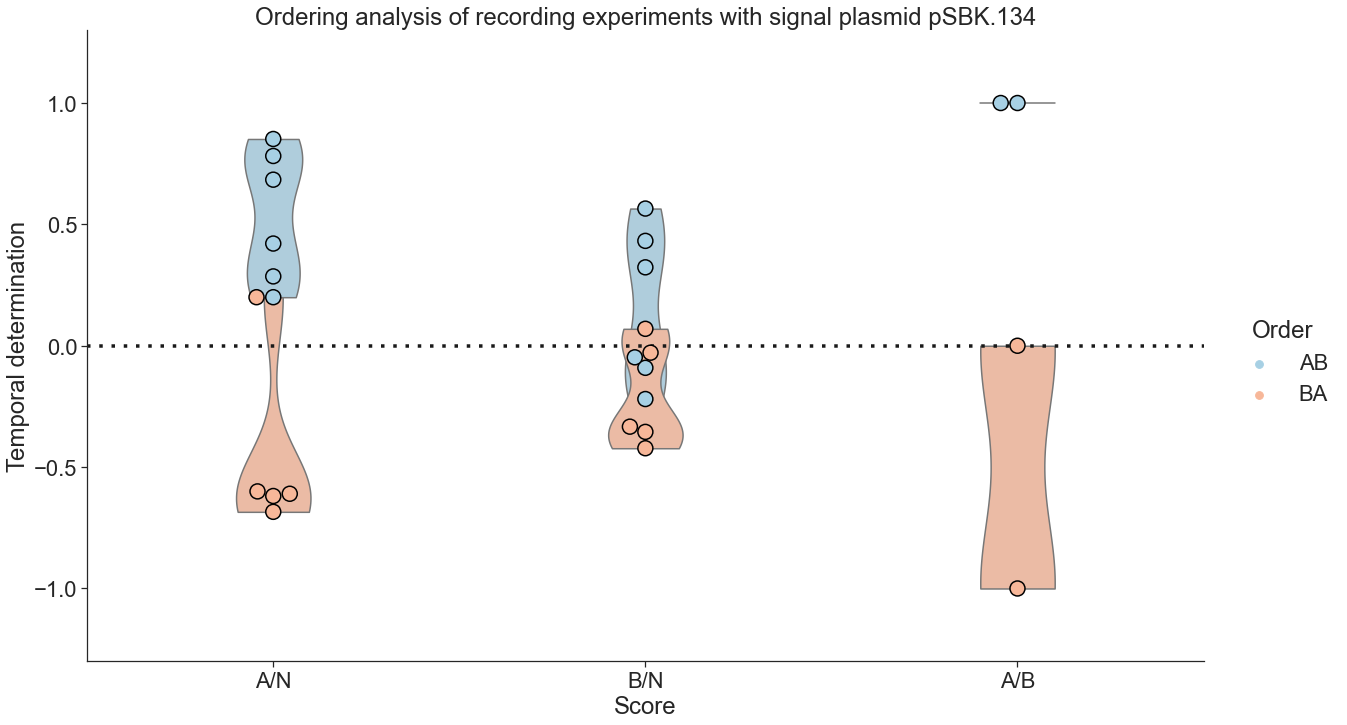

In [261]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title="Ordering analysis of recording experiments with signal plasmid pSBK.134")

g.savefig("ordering_analysis_134_summed.pdf")

end pt. 1

------

# Simulations

### Make simulated figures for different ordering scores and show how that would affect interpretation of the figure

*Snippet adapted from the methods section of Bhattarai-Kline et. al 2022, Nature:*     
We assume that spacer acquisition is well approximated as a Poisson process in which acquisitions occur at some average rate over time but where the precise timing of these events is random and independent of the timing of previous events.       
We believe that this is a fair approximation of spacer acquisition because of the overall low rate of spacer acquisition in the retron recording system (single-digit percentages of arrays expanded over 24 h), the demonstrated ability of CRISPR arrays to be multiply expanded and the current understanding of CRISPR adaptation indicating that acquisitions occur one at a time.       
To simulate spacer acquisition in a population of cells, $N$ unexpanded arrays are generated, where $N$ is user-specified. Given user-specified "on" and "off" rates for promoters $A$ and $B$, as well as the (assumed constant) rate of $N$ spacer acquisitions, each array samples three different Poisson distributions (one each for signals A, B and N) to determine the number of spacers of each type that are added to its array during the epoch. The order of these spacers is then randomized and appended to the array.     
     
*For example, when the order of induction is A before B, the cell is subject to the following rates of acquisition: A with inducer, B without inducer and N.* 
    
For each signal, the cell samples a Poisson distribution defined by the probability mass function $p(k;\lambda)=\frac{\lambda^{k}e^{-\lambda}}{k!}$ where $k$ is the number of acquisitions of that signal ($k = 0, 1, 2, …$) and $\lambda$ is the expected number of acquisitions of that signal (defined as the rate of acquisition of a given signal multiplied by the length of the epoch). 

It is fair to randomize the order of acquisitions occurring in each epoch, before appending them to the array, because the timing of the events is random by definition. For example, given that a cell acquires an $A$ spacer and an $N$ spacer in an interval with constant rates of acquisition of $A$ and $N$, it is equally likely that $A$ comes before $N$ as it is that $N$ comes before $A$.        

After acquisitions during the first epoch are completed, the process is repeated for the second epoch, using the corresponding relevant rates of acquisition. At this point, the arrays are complete and ready for analysis using the ordering rules.

#### Define `gen_arrays`, a function that will simulate the spacer acquisition process; and `run_sim`, a function that will run the simulation. 

In [372]:
### code adapted from Santi Bhattarai-Kline's simulation scripts, also available on our lab GitHub

def gen_arrays(p_A_on, p_A_off, p_B_on, p_B_off, p_N, n_arrays, p, f):
    """
    takes as input the A-derived “on” and “off” rates, 
    the B-derived “on” and “off” rates, the N spacer rate, 
    the number of arrays to in silico expand, the PCR number, 
    and the correction factor. The rates are in numbers of 
    expansions per epoch (~24h); the PCR number and the 
    “biological replicate” number (not a parameter of the function) 
    allows users to generate simulations that correspond to 
    experimental conditions; the correction factor was 
    implemented to allow users to run simulations faster – 
    it is a scaling factor that increases the promoter “on” 
    and “off” rates by the same factor as it decreases the 
    number of simulated arrays, allowing for faster iteration times. 
    To simulate array expansion, N unexpanded arrays are generated, 
    where N is user-specified. Given user-specified "on" and "off" 
    rates for promoters A and $B$, as well as the (assumed constant) 
    rate of N spacer acquisitions, each array samples three different 
    Poisson distributions (one each for signals A, B and N) 
    to determine the number of spacers of each type that are 
    added to its array during the epoch. The order of these spacers 
    is then randomized and appended to the array.
    """
    
    array_list = ["" for i in range(n_arrays)]
    
    file = f
    
    ## run first epoch
    for i in range(len(array_list)):
        
        t = '' + ("A" * int(np.random.poisson((p_A_on), 1)))\
               + ("B" * int(np.random.poisson((p_B_off), 1)))\
               + ('N' * int(np.random.poisson((p_N), 1)))
        
        if len(t) > 1:
            array_list[i] += random.choice(t)
        elif len(t) == 1:
            array_list[i] += t
                    
    ## run second epoch
    for i in range(len(array_list)):
        t = '' + ("A" * int(np.random.poisson((p_A_off), 1)))\
               + ("B" * int(np.random.poisson((p_B_on), 1)))\
               + ('N' * int(np.random.poisson((p_N), 1)))
        if len(t) > 1:
            array_list[i] += random.choice(t)
        elif len(t) == 1:
            array_list[i] += t

        # extract data 
        if len(array_list[i])>0:
            double_dict[file]["total expanded"] +=1
            spacers = [s for s in array_list[i]]
            for s in spacers:
                double_dict[file][s] +=1
            if len(spacers) == 2:
                double_dict[file][(spacers[0], spacers[1])] +=1

    double_dict[file]["total reads"] = n_arrays*corr_factor 
    double_dict[file]["PCR"] = p
    return double_dict[file]

# runs the simulation
def run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor):
    
    """
    a wrapper function that runs the simulations by calling 
    `gen_arrays` on a series of global variables. As such, 
    it takes as input the same parameters as `gen_arrays`, 
    as well as a couple of other global variables: 
    dictionaries to store the collected data (`count_dict` 
    and `double_dict`), a list of double expansion ordering 
    possibilities (`double_options`), and the user-specified 
    transcriptional program (`order`). For instance, `order` 
    can be “AB”, which specifies a transcriptional where 
    promoter A is on during epoch 1, then promoter B is on 
    during epoch 2.
    """

    for o in order:
        for rep in bioreps:
            for p in pcrs: 
                file = rep

                double_dict[file] = {}

                for double in double_options:
                    double_dict[file][double] = 0

                double_dict[file]["total reads"] = 0
                double_dict[file]["total expanded"] = 0
                double_dict[file]["A"] = 0
                double_dict[file]["B"] = 0
                double_dict[file]["N"] = 0
                double_dict[file]["Order"] = o

                if o == "AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_off*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                elif o == "BA":
                    ddd = gen_arrays(p_A_off*corr_factor, p_A_on*corr_factor, 
                               p_B_off*corr_factor, p_B_on*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                
                elif o == "A/AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                    
                elif o == "-/AB":
                    ddd = gen_arrays(p_A_off*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                
                elif o == "AB/AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_on*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)

                count_dict[file+"_"+str(p)+"_"+str(o)] =  ddd


For the sake of the simulation and its interpretability, we’ve deliberately chosen matched promoter strengths and leakiness for A and B, which nonetheless correspond to the rates we estimated from our experimental data. In terms of simulating arrays, we opted for 300'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total).      
The actual total of number of reads per biological replicate will vary, as we generate a random number of arrays, sampled from a normal distribution centered around 300’000, with a standard deviation of 45’000. This is meant to simulate the experimental noise introduced during the Illumina sample preparation, quantification and pooling for sequencing.    
* **Scenario 1**: similar transcriptional recording experiment as in Figure 4L (pSBK134 $A \to B$ // $B \to A$)
    - Order of events: A turned on during epoch 1; B turned on during epoch 2
* **Scenario 2**: A; A+B
    - Order of events: A turned on during epoch 1; A and B turned on during epoch 2
* **Scenario 3**: none; A+B
    - Order of events: neither is turned on during epoch 1; A and B turned on during epoch 2
* **Scenario 4**: A+B; A+B
    - Order of events: A and B turned on during epoch 1; A and B turned on during epoch 2


------------

#### Scenario 1: similar transcriptional recording experiment as in Figure 4L of Bhattarai-Kline et al., 2022 (pSBK134 $A \to B$ // $B \to A$)
* **Order of events**: A turned on during epoch 1; B turned on during epoch 2
* **Promoter strength**: A and B are matched
* **Promoter leakiness**: A and B are matched

300'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [373]:
import random

double_options = [prod for prod in itertools.product('ABN', repeat=2)]

## sbk rates
# rate_A_on = 6.46E-5
# rate_A_off = 1.21E-5
# rate_B_on = 6.47E-5
# rate_B_off = 4.37E-5
# rate_N = 1.41E-3

## default params
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 300000
corr_factor = 1

count_dict = {}
double_dict = {}

order = ["AB", "BA"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor)

In [374]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[0]
display (small_df.tail(6))


small_df_summed_counts = small_df[[("A", "B"), ("A", "N"), ("B", "A"), ("B", "N"), ("N", "A"), ("N", "B"), "Order", "Replicate"]].groupby(["Order", "Replicate"]).sum().reset_index(level=["Order"]).reset_index()
small_df_summed_counts

,Exact filename,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)",total reads,total expanded,A,B,N,Order,PCR,Replicate
66,FQ6_1_BA,0,0,0,0,0,2,1,0,46,273066,8099,219,254,7675,BA,1,FQ6
67,FQ6_2_BA,0,0,0,0,0,2,0,0,49,232397,6762,167,163,6483,BA,2,FQ6
68,FQ6_3_BA,0,0,0,0,0,2,0,1,66,350322,10238,251,270,9786,BA,3,FQ6
69,FQ6_4_BA,0,0,2,0,0,2,3,1,74,335132,9908,245,242,9503,BA,4,FQ6
70,FQ6_5_BA,0,0,0,0,0,2,1,0,39,221708,6491,161,190,6182,BA,5,FQ6
71,FQ6_6_BA,0,0,0,1,0,1,0,1,63,255248,7520,213,196,7177,BA,6,FQ6


/Users/slopez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


,Replicate,Order,"(A, B)","(A, N)","(B, A)","(B, N)","(N, A)","(N, B)"
0,FQ1,AB,1,20,0,7,5,27
1,FQ2,AB,1,18,0,0,1,17
2,FQ3,AB,1,12,0,4,2,18
3,FQ4,AB,0,19,0,2,1,15
4,FQ5,AB,3,14,0,3,3,19
5,FQ6,AB,0,22,0,2,2,14
6,FQ1,BA,0,2,0,16,15,2
7,FQ2,BA,0,3,0,16,8,3
8,FQ3,BA,0,5,2,24,13,3
9,FQ4,BA,0,2,2,21,17,5


In [375]:
small_df_summed_counts["A/N"] = (small_df_summed_counts[('A', 'N')].astype(float)-small_df_summed_counts[('N', 'A')].astype(float))/(small_df_summed_counts[('A', 'N')].astype(float)+small_df_summed_counts[('N', 'A')].astype(float))
small_df_summed_counts["B/N"] = (small_df_summed_counts[('N', 'B')].astype(float)-small_df_summed_counts[('B', 'N')].astype(float))/(small_df_summed_counts[('B', 'N')].astype(float)+small_df_summed_counts[('N', 'B')].astype(float))
small_df_summed_counts["A/B"] = (small_df_summed_counts[('A', 'B')].astype(float)-small_df_summed_counts[('B', 'A')].astype(float))/(small_df_summed_counts[('A', 'B')].astype(float)+small_df_summed_counts[('B', 'A')].astype(float))


df_AN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
small_summarized_df = pd.concat([df_AN, df_BN, df_AB])
#summarized_df.to_csv("summarized_data_ordering.csv")
display(small_summarized_df)


,Order,Replicate,Score,Type
0,AB,FQ1,0.600000,A/N
1,AB,FQ2,0.894737,A/N
2,AB,FQ3,0.714286,A/N
3,AB,FQ4,0.900000,A/N
4,AB,FQ5,0.647059,A/N
5,AB,FQ6,0.833333,A/N
6,BA,FQ1,-0.764706,A/N
7,BA,FQ2,-0.454545,A/N
8,BA,FQ3,-0.444444,A/N
9,BA,FQ4,-0.789474,A/N


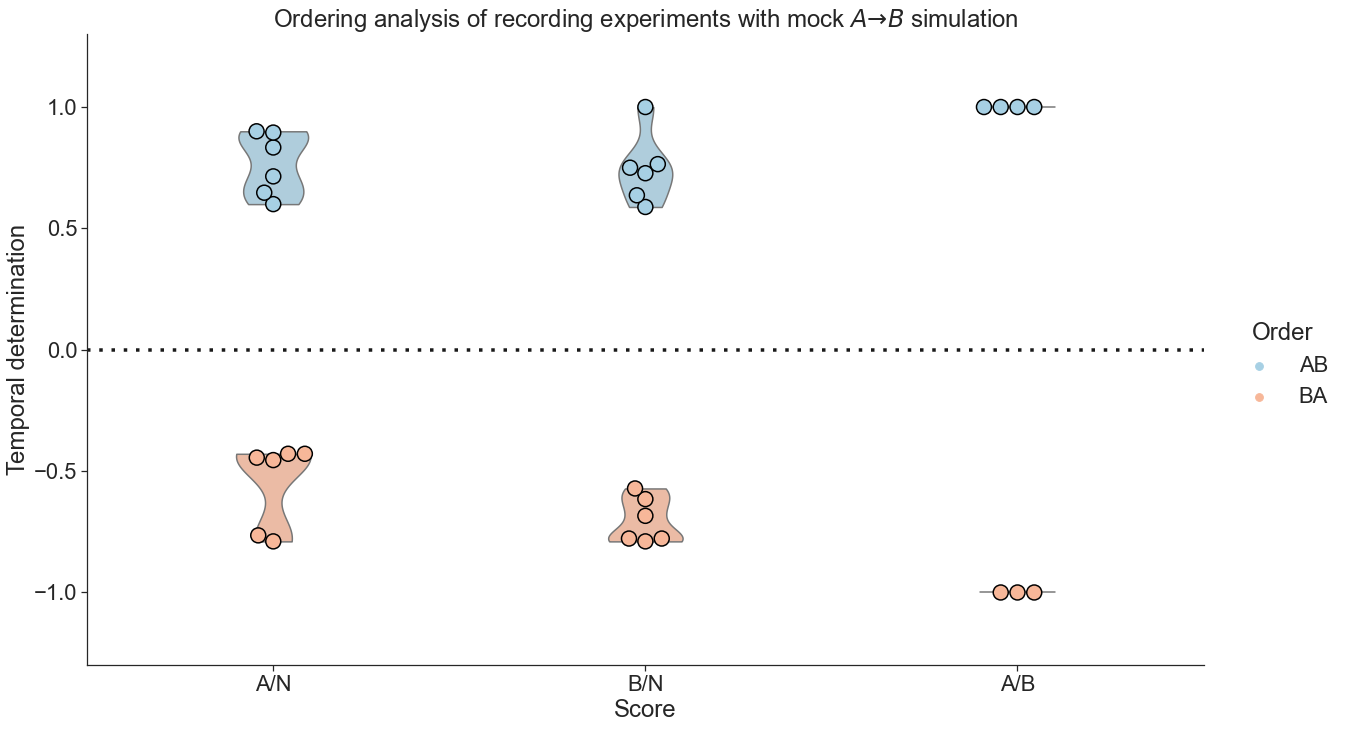

In [376]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=small_summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=small_summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $A \to B$ simulation")

g.savefig("ordering_analysis_summed_A-B_B-A_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

#### Scenario 2: A; A+B
* **Order of events**: A turned on during epoch 1; A+B turned on during epoch 2
* **Promoter strength**: A and B are matched
* **Promoter leakiness**: A and B are matched

300'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [377]:
## good rates
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 300000
corr_factor = 1

count_dict = {}
double_dict = {}


order = ["A/AB"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor)


In [378]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[0]
display (small_df.tail(6))

small_df_summed_counts = small_df[[("A", "B"), ("A", "N"), ("B", "A"), ("B", "N"), ("N", "A"), ("N", "B"), "Order", "Replicate"]].groupby(["Order", "Replicate"]).sum().reset_index(level=["Order"]).reset_index()
small_df_summed_counts

,Exact filename,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)",total reads,total expanded,A,B,N,Order,PCR,Replicate
30,FQ6_1_A/AB,1,0,1,0,0,1,0,2,42,248432,7410,320,173,6964,A/AB,1,FQ6
31,FQ6_2_A/AB,0,0,4,0,0,1,3,3,71,368270,11046,471,281,10376,A/AB,2,FQ6
32,FQ6_3_A/AB,0,0,5,0,1,0,4,1,47,247978,7357,318,176,6921,A/AB,3,FQ6
33,FQ6_4_A/AB,1,0,5,0,0,1,2,2,58,284127,8517,360,232,7994,A/AB,4,FQ6
34,FQ6_5_A/AB,0,0,0,0,0,0,3,3,40,260088,7868,313,212,7389,A/AB,5,FQ6
35,FQ6_6_A/AB,0,0,3,0,0,0,3,0,67,334070,9955,390,242,9396,A/AB,6,FQ6


/Users/slopez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


,Replicate,Order,"(A, B)","(A, N)","(B, A)","(B, N)","(N, A)","(N, B)"
0,FQ1,A/AB,1,18,0,1,18,16
1,FQ2,A/AB,1,14,0,3,14,26
2,FQ3,A/AB,1,13,1,0,25,23
3,FQ4,A/AB,1,25,0,1,10,18
4,FQ5,A/AB,1,10,0,1,14,20
5,FQ6,A/AB,0,18,0,3,15,11


In [379]:
small_df_summed_counts["A/N"] = (small_df_summed_counts[('A', 'N')].astype(float)-small_df_summed_counts[('N', 'A')].astype(float))/(small_df_summed_counts[('A', 'N')].astype(float)+small_df_summed_counts[('N', 'A')].astype(float))
small_df_summed_counts["B/N"] = (small_df_summed_counts[('N', 'B')].astype(float)-small_df_summed_counts[('B', 'N')].astype(float))/(small_df_summed_counts[('B', 'N')].astype(float)+small_df_summed_counts[('N', 'B')].astype(float))
small_df_summed_counts["A/B"] = (small_df_summed_counts[('A', 'B')].astype(float)-small_df_summed_counts[('B', 'A')].astype(float))/(small_df_summed_counts[('A', 'B')].astype(float)+small_df_summed_counts[('B', 'A')].astype(float))


df_AN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
small_summarized_df = pd.concat([df_AN, df_BN, df_AB])
#summarized_df.to_csv("summarized_data_ordering.csv")
display(small_summarized_df)


,Order,Replicate,Score,Type
0,A/AB,FQ1,0.000000,A/N
1,A/AB,FQ2,0.000000,A/N
2,A/AB,FQ3,-0.315789,A/N
3,A/AB,FQ4,0.428571,A/N
4,A/AB,FQ5,-0.166667,A/N
5,A/AB,FQ6,0.090909,A/N
0,A/AB,FQ1,0.882353,B/N
1,A/AB,FQ2,0.793103,B/N
2,A/AB,FQ3,1.000000,B/N
3,A/AB,FQ4,0.894737,B/N


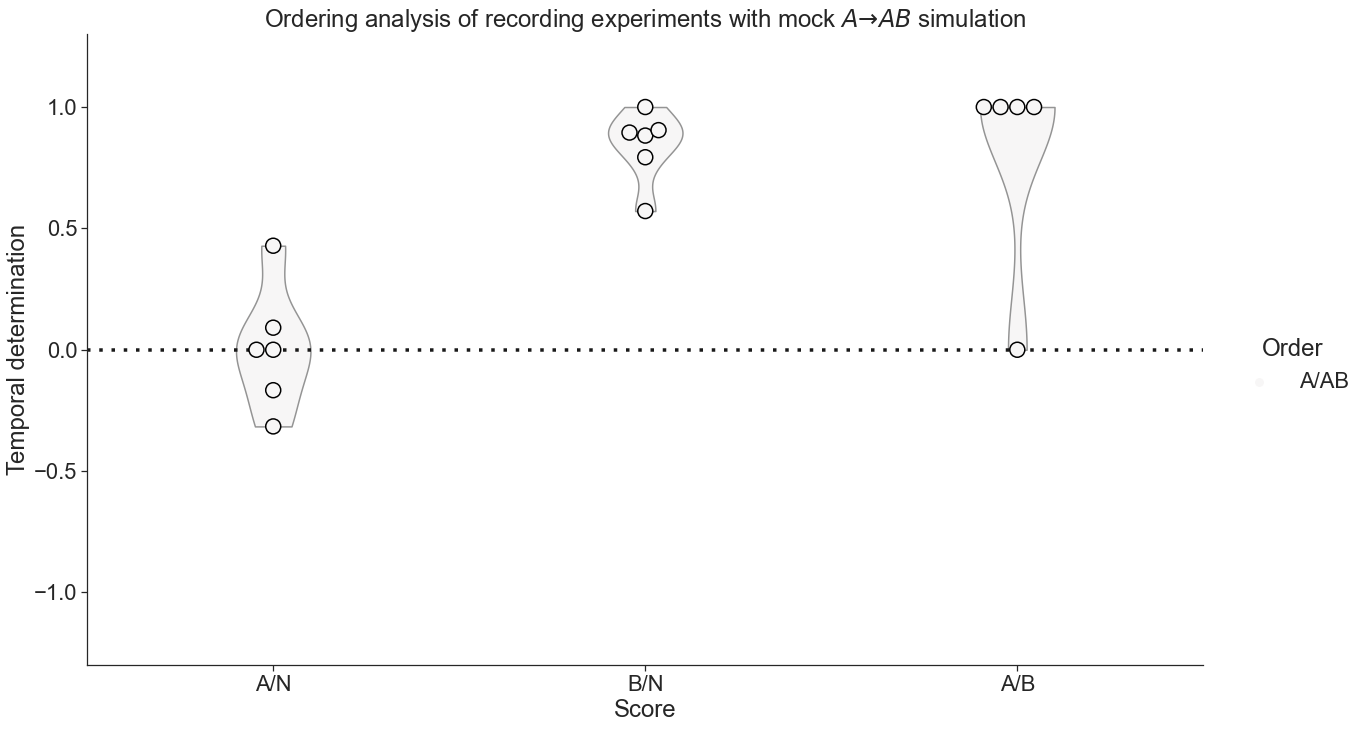

In [380]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=small_summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=small_summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $A \to AB$ simulation")

g.savefig("ordering_analysis_summed_A-AB_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

#### Scenario 3: none; A+B
* **Order of events**: neither is turned on during epoch 1; A+B turned on during epoch 2
* **Promoter strength**: A and B are matched
* **Promoter leakiness**: A and B are matched

300'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [381]:
## good rates
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 300000
corr_factor = 1

count_dict = {}
double_dict = {}


order = ["-/AB"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor)

In [382]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[0]
display (small_df.tail(6))


small_df_summed_counts = small_df[[("A", "B"), ("A", "N"), ("B", "A"), ("B", "N"), ("N", "A"), ("N", "B"), "Order", "Replicate"]].groupby(["Order", "Replicate"]).sum().reset_index(level=["Order"]).reset_index()
small_df_summed_counts

,Exact filename,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)",total reads,total expanded,A,B,N,Order,PCR,Replicate
30,FQ6_1_-/AB,0,0,0,0,0,0,5,3,56,332363,9573,232,254,9151,-/AB,1,FQ6
31,FQ6_2_-/AB,0,0,0,0,0,1,3,2,38,239246,7012,169,200,6687,-/AB,2,FQ6
32,FQ6_3_-/AB,1,0,0,0,0,0,3,7,44,266643,7836,211,215,7465,-/AB,3,FQ6
33,FQ6_4_-/AB,0,0,1,0,0,0,3,2,47,323507,9312,237,245,8883,-/AB,4,FQ6
34,FQ6_5_-/AB,0,0,1,0,0,2,1,2,44,219999,6439,157,165,6167,-/AB,5,FQ6
35,FQ6_6_-/AB,0,0,1,0,0,1,3,3,65,331765,9754,259,245,9323,-/AB,6,FQ6


/Users/slopez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


,Replicate,Order,"(A, B)","(A, N)","(B, A)","(B, N)","(N, A)","(N, B)"
0,FQ1,-/AB,0,3,1,4,11,23
1,FQ2,-/AB,1,4,0,2,18,20
2,FQ3,-/AB,1,2,0,2,17,17
3,FQ4,-/AB,0,0,0,1,15,13
4,FQ5,-/AB,0,2,0,2,28,21
5,FQ6,-/AB,0,3,0,4,18,19


In [383]:
small_df_summed_counts["A/N"] = (small_df_summed_counts[('A', 'N')].astype(float)-small_df_summed_counts[('N', 'A')].astype(float))/(small_df_summed_counts[('A', 'N')].astype(float)+small_df_summed_counts[('N', 'A')].astype(float))
small_df_summed_counts["B/N"] = (small_df_summed_counts[('N', 'B')].astype(float)-small_df_summed_counts[('B', 'N')].astype(float))/(small_df_summed_counts[('B', 'N')].astype(float)+small_df_summed_counts[('N', 'B')].astype(float))
small_df_summed_counts["A/B"] = (small_df_summed_counts[('A', 'B')].astype(float)-small_df_summed_counts[('B', 'A')].astype(float))/(small_df_summed_counts[('A', 'B')].astype(float)+small_df_summed_counts[('B', 'A')].astype(float))


df_AN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
small_summarized_df = pd.concat([df_AN, df_BN, df_AB])
#summarized_df.to_csv("summarized_data_ordering.csv")
display(small_summarized_df)


,Order,Replicate,Score,Type
0,-/AB,FQ1,-0.571429,A/N
1,-/AB,FQ2,-0.636364,A/N
2,-/AB,FQ3,-0.789474,A/N
3,-/AB,FQ4,-1.000000,A/N
4,-/AB,FQ5,-0.866667,A/N
5,-/AB,FQ6,-0.714286,A/N
0,-/AB,FQ1,0.703704,B/N
1,-/AB,FQ2,0.818182,B/N
2,-/AB,FQ3,0.789474,B/N
3,-/AB,FQ4,0.857143,B/N


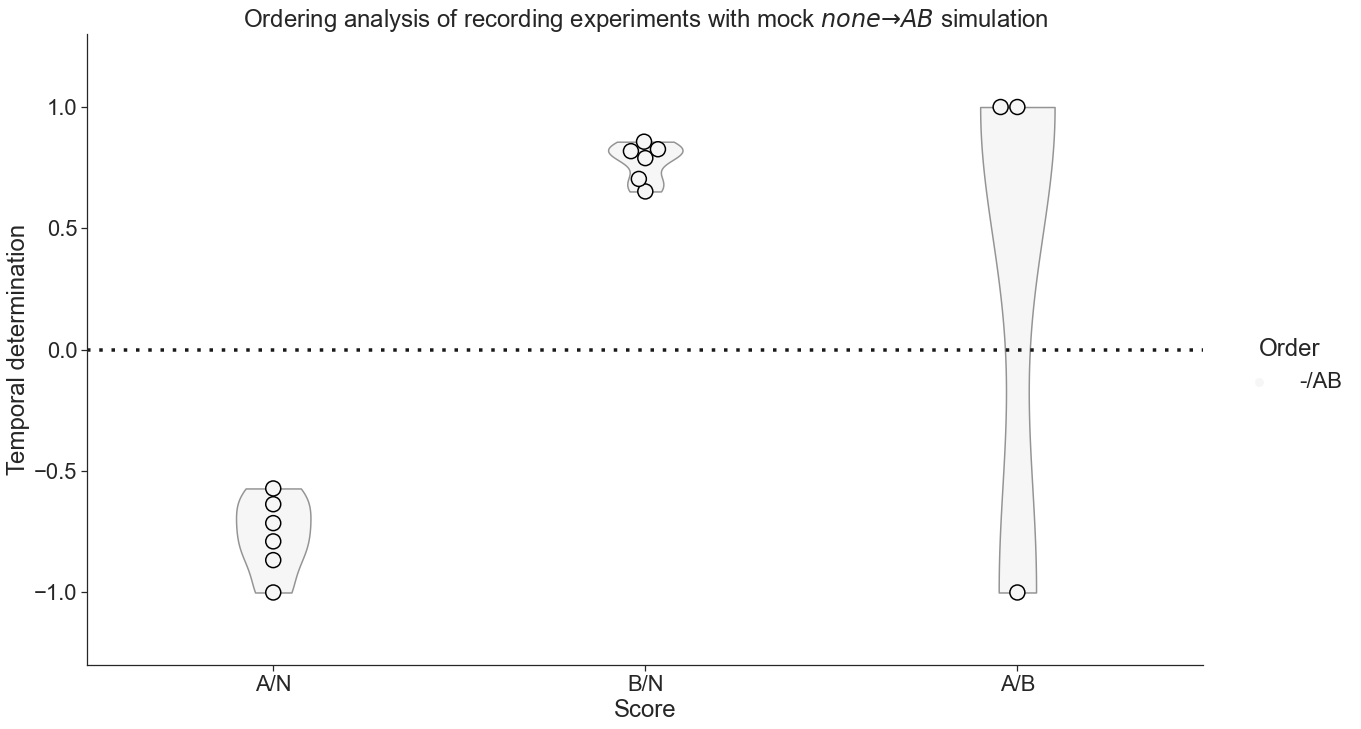

In [384]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=small_summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=small_summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $none \to AB$ simulation")

g.savefig("ordering_analysis_summed_none-AB_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

#### Scenario 4: A+B; A+B
* **Order of events**: A+B turned on during epoch 1; A+B turned on during epoch 2
* **Promoter strength**: A and B are matched
* **Promoter leakiness**: A and B are matched

300'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [385]:
## good rates
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 300000
corr_factor = 1

count_dict = {}
double_dict = {}


order = ["AB/AB"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor)

In [386]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[0]
display (small_df.tail(6))


small_df_summed_counts = small_df[[("A", "B"), ("A", "N"), ("B", "A"), ("B", "N"), ("N", "A"), ("N", "B"), "Order", "Replicate"]].groupby(["Order", "Replicate"]).sum().reset_index(level=["Order"]).reset_index()
small_df_summed_counts

,Exact filename,"(A, A)","(A, B)","(A, N)","(B, A)","(B, B)","(B, N)","(N, A)","(N, B)","(N, N)",total reads,total expanded,A,B,N,Order,PCR,Replicate
30,FQ6_1_AB/AB,1,0,6,0,0,3,2,7,58,379562,11286,501,510,10352,AB/AB,1,FQ6
31,FQ6_2_AB/AB,0,0,4,0,0,3,3,4,67,369906,11195,513,487,10276,AB/AB,2,FQ6
32,FQ6_3_AB/AB,0,0,4,0,0,6,1,2,56,269622,8146,359,335,7521,AB/AB,3,FQ6
33,FQ6_4_AB/AB,0,0,4,1,0,1,0,2,59,320465,9810,414,392,9071,AB/AB,4,FQ6
34,FQ6_5_AB/AB,0,0,4,0,0,1,5,4,54,301129,9069,388,389,8360,AB/AB,5,FQ6
35,FQ6_6_AB/AB,0,0,1,0,0,2,0,4,65,278286,8386,328,379,7751,AB/AB,6,FQ6


/Users/slopez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


,Replicate,Order,"(A, B)","(A, N)","(B, A)","(B, N)","(N, A)","(N, B)"
0,FQ1,AB/AB,1,15,1,25,26,14
1,FQ2,AB/AB,1,19,0,19,14,18
2,FQ3,AB/AB,3,12,0,19,15,15
3,FQ4,AB/AB,1,18,0,11,7,19
4,FQ5,AB/AB,0,18,1,18,19,20
5,FQ6,AB/AB,0,23,1,16,11,23


In [387]:
small_df_summed_counts["A/N"] = (small_df_summed_counts[('A', 'N')].astype(float)-small_df_summed_counts[('N', 'A')].astype(float))/(small_df_summed_counts[('A', 'N')].astype(float)+small_df_summed_counts[('N', 'A')].astype(float))
small_df_summed_counts["B/N"] = (small_df_summed_counts[('N', 'B')].astype(float)-small_df_summed_counts[('B', 'N')].astype(float))/(small_df_summed_counts[('B', 'N')].astype(float)+small_df_summed_counts[('N', 'B')].astype(float))
small_df_summed_counts["A/B"] = (small_df_summed_counts[('A', 'B')].astype(float)-small_df_summed_counts[('B', 'A')].astype(float))/(small_df_summed_counts[('A', 'B')].astype(float)+small_df_summed_counts[('B', 'A')].astype(float))


df_AN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
small_summarized_df = pd.concat([df_AN, df_BN, df_AB])
#summarized_df.to_csv("summarized_data_ordering.csv")
display(small_summarized_df)


,Order,Replicate,Score,Type
0,AB/AB,FQ1,-0.268293,A/N
1,AB/AB,FQ2,0.151515,A/N
2,AB/AB,FQ3,-0.111111,A/N
3,AB/AB,FQ4,0.440000,A/N
4,AB/AB,FQ5,-0.027027,A/N
5,AB/AB,FQ6,0.352941,A/N
0,AB/AB,FQ1,-0.282051,B/N
1,AB/AB,FQ2,-0.027027,B/N
2,AB/AB,FQ3,-0.117647,B/N
3,AB/AB,FQ4,0.266667,B/N


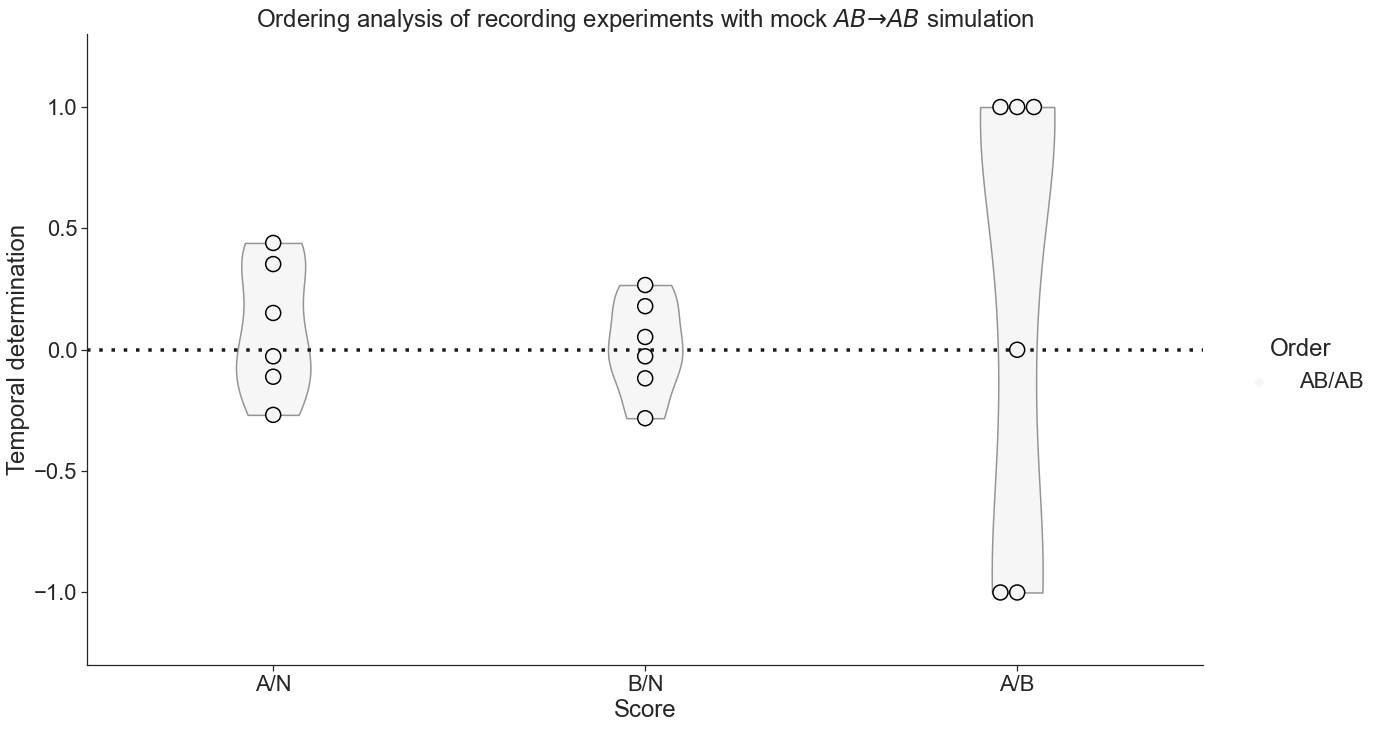

In [388]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=small_summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=small_summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $AB \to AB$ simulation")

g.savefig("ordering_analysis_summed_AB-AB_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

## Simulation: plot scores vs. number of informative arrays, at different sequencing depths 

As before, define functions to generate arrays and run the simulation

In [389]:
### code adapted from Santi Bhattarai-Kline's simulation scripts, also available on our lab GitHub

def gen_arrays(p_A_on, p_A_off, p_B_on, p_B_off, p_N, n_arrays, p, f):
    """
    takes as input the A-derived “on” and “off” rates, 
    the B-derived “on” and “off” rates, the N spacer rate, 
    the number of arrays to in silico expand, the PCR number, 
    and the correction factor. The rates are in numbers of 
    expansions per epoch (~24h); the PCR number and the 
    “biological replicate” number (not a parameter of the function) 
    allows users to generate simulations that correspond to 
    experimental conditions; the correction factor was 
    implemented to allow users to run simulations faster – 
    it is a scaling factor that increases the promoter “on” 
    and “off” rates by the same factor as it decreases the 
    number of simulated arrays, allowing for faster iteration times. 
    To simulate array expansion, N unexpanded arrays are generated, 
    where N is user-specified. Given user-specified "on" and "off" 
    rates for promoters A and $B$, as well as the (assumed constant) 
    rate of N spacer acquisitions, each array samples three different 
    Poisson distributions (one each for signals A, B and N) 
    to determine the number of spacers of each type that are 
    added to its array during the epoch. The order of these spacers 
    is then randomized and appended to the array.
    """
    
    array_list = ["" for i in range(n_arrays)]
    
    file = f
    
    ## run first epoch
    for i in range(len(array_list)):
        
        t = '' + ("A" * int(np.random.poisson((p_A_on), 1)))\
               + ("B" * int(np.random.poisson((p_B_off), 1)))\
               + ('N' * int(np.random.poisson((p_N), 1)))
        
        if len(t) > 1:
            array_list[i] += random.choice(t)
        elif len(t) == 1:
            array_list[i] += t
                    
    ## run second epoch
    for i in range(len(array_list)):
        t = '' + ("A" * int(np.random.poisson((p_A_off), 1)))\
               + ("B" * int(np.random.poisson((p_B_on), 1)))\
               + ('N' * int(np.random.poisson((p_N), 1)))
        if len(t) > 1:
            array_list[i] += random.choice(t)
        elif len(t) == 1:
            array_list[i] += t

        # extract data 
        if len(array_list[i])>0:
            double_dict[file]["total expanded"] +=1
            spacers = [s for s in array_list[i]]
            for s in spacers:
                double_dict[file][s] +=1
            if len(spacers) == 2:
                double_dict[file][(spacers[0], spacers[1])] +=1

    double_dict[file]["total reads"] = n_arrays*corr_factor 
    double_dict[file]["PCR"] = p
    return double_dict[file]

# runs the simulation
def run_sim(double_options, order, bioreps, pcrs,
           count_dict, double_dict,
           p_A_on, p_A_off, 
            p_B_on, p_B_off, 
            p_N, n_arrays, corr_factor):
    
    """
    a wrapper function that runs the simulations by calling 
    `gen_arrays` on a series of global variables. As such, 
    it takes as input the same parameters as `gen_arrays`, 
    as well as a couple of other global variables: 
    dictionaries to store the collected data (`count_dict` 
    and `double_dict`), a list of double expansion ordering 
    possibilities (`double_options`), and the user-specified 
    transcriptional program (`order`). For instance, `order` 
    can be “AB”, which specifies a transcriptional where 
    promoter A is on during epoch 1, then promoter B is on 
    during epoch 2.
    """

    for o in order:
        for rep in bioreps:
            for p in pcrs: 
                file = rep

                double_dict[file] = {}

                for double in double_options:
                    double_dict[file][double] = 0

                double_dict[file]["total reads"] = 0
                double_dict[file]["total expanded"] = 0
                double_dict[file]["A"] = 0
                double_dict[file]["B"] = 0
                double_dict[file]["N"] = 0
                double_dict[file]["Order"] = o
                double_dict[file]["n_arrays"] = arr

                if o == "AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_off*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                elif o == "BA":
                    ddd = gen_arrays(p_A_off*corr_factor, p_A_on*corr_factor, 
                               p_B_off*corr_factor, p_B_on*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                
                elif o == "A/AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                    
                elif o == "-/AB":
                    ddd = gen_arrays(p_A_off*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_off*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)
                
                elif o == "AB/AB":
                    ddd = gen_arrays(p_A_on*corr_factor, p_A_on*corr_factor, 
                               p_B_on*corr_factor, p_B_on*corr_factor,
                               p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p, file)

                count_dict[file+"_"+str(p)+"_"+str(o)+"_"+str(arr)] =  ddd


### Run the simulation
The cell below will run the simulation for an experiment where the transcriptional program is $A \to B$, and with the same rates as those used above.   
Here, for the sake of compensating for the informative array sparseness and to illustrate the point better, we have chosen to simulate 18 biological replicates, with 6 PCRs each, for a range of arrays to be simulated. These range from 500 arrays to 1 million arrays per PCR.

In [661]:
import random
double_options = [prod for prod in itertools.product('ABN', repeat=2)]

p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
corr_factor = 1

count_dict = {}
double_dict = {}


order = ["AB"]#, "BA"]
bioreps = ["FQ1", "FQ2", "FQ3", 
           "FQ4", "FQ5", "FQ6",
           "FQ7", "FQ8", "FQ9",
           "FQ10", "FQ11", "F12",
           "FQ13", "FQ14", "FQ15",
           "FQ16", "FQ17", "FQ18"]
pcrs = ["1","2","3","4","5", "6"]
n_arrays = [500, 750, 1000, 1500, 2000,
            2500, 5000, 6000, 7000, 8000,
            9000, 10000, 12000, 15000, 17500,
            20000, 25000, 40000, 60000, 80000,
            100000, 120000, 140000, 160000,
            180000, 200000, 300000, 400000, 
            600000, 800000, 1000000]
            #200000, 500000, 800000, 1000000, 1250000]
            #500000, 1000000]
            #3000000, 30000000]

for arr in n_arrays:    
    print (arr)
    run_sim(double_options, order, bioreps, pcrs,
               count_dict, double_dict,
               p_A_on, p_A_off, 
                p_B_on, p_B_off, 
                p_N, arr, corr_factor)

500
750
1000
1500
2000
2500
5000
6000
7000
8000
9000
10000
12000
15000
17500
20000
25000
40000
60000
80000
100000
120000
140000
160000
180000
200000
300000
400000
600000
800000
1000000


Add the data to a dataframe, `small_df`, that will allow us to keep track of the number of informative arrays per experiment.

In [662]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[0]
#display(small_df[["PCR", "Replicate"]])

small_df_summed_counts = small_df[[("A", "B"), ("A", "N"), ("B", "A"), ("B", "N"), ("N", "A"), ("N", "B"), "Order", "Replicate", 'n_arrays']].groupby(["Order", "Replicate",  'n_arrays']).sum().reset_index(level=["Order"]).reset_index()

small_df_summed_counts["n_informative_arrays"] = small_df_summed_counts[("A","B")]+ small_df_summed_counts[("B","A")]+small_df_summed_counts[("A","N")]+small_df_summed_counts[("N","A")] + small_df_summed_counts[("B","N")]+small_df_summed_counts[("N","B")]

/Users/slopez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [663]:
small_df_summed_counts.sort_values(["n_arrays"])

,Replicate,n_arrays,Order,"(A, B)","(A, N)","(B, A)","(B, N)","(N, A)","(N, B)",n_informative_arrays
0,F12,500,AB,0,0,0,0,0,1,1
155,FQ14,500,AB,0,0,0,0,0,0,0
124,FQ13,500,AB,0,0,0,0,0,0,0
372,FQ4,500,AB,0,0,0,0,0,0,0
403,FQ5,500,AB,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
402,FQ4,1000000,AB,3,50,0,10,11,59,133
433,FQ5,1000000,AB,4,42,0,11,12,59,128
464,FQ6,1000000,AB,2,57,0,9,2,55,125
247,FQ16,1000000,AB,3,51,1,15,10,44,124


In [753]:
small_df_summed_counts["A/N"] = (small_df_summed_counts[('A', 'N')].astype(float)-small_df_summed_counts[('N', 'A')].astype(float))/(small_df_summed_counts[('A', 'N')].astype(float)+small_df_summed_counts[('N', 'A')].astype(float))
small_df_summed_counts["B/N"] = (small_df_summed_counts[('N', 'B')].astype(float)-small_df_summed_counts[('B', 'N')].astype(float))/(small_df_summed_counts[('B', 'N')].astype(float)+small_df_summed_counts[('N', 'B')].astype(float))
small_df_summed_counts["A/B"] = (small_df_summed_counts[('A', 'B')].astype(float)-small_df_summed_counts[('B', 'A')].astype(float))/(small_df_summed_counts[('A', 'B')].astype(float)+small_df_summed_counts[('B', 'A')].astype(float))

df_AN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'n_informative_arrays', 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'n_informative_arrays', 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df_summed_counts[['Order', "Replicate", 'n_informative_arrays', 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
small_summarized_df = pd.concat([df_AN, df_BN, df_AB])
#summarized_df.to_csv("summarized_data_ordering.csv")
#display(small_summarized_df)

In [754]:
small_summarized_df

,Order,Replicate,n_informative_arrays,Score,Type
0,AB,F12,1,NaN,A/N
1,AB,F12,1,NaN,A/N
2,AB,F12,1,NaN,A/N
3,AB,F12,0,NaN,A/N
4,AB,F12,0,NaN,A/N
...,...,...,...,...,...
553,AB,FQ9,41,1.0,A/B
554,AB,FQ9,51,1.0,A/B
555,AB,FQ9,90,1.0,A/B
556,AB,FQ9,108,1.0,A/B


This will be more useful later, but fill the NaN values with a string "NaN".

In [755]:
summarized_df_na0 = small_summarized_df.fillna("NaN")

Plot the ordering scores vs. number of informative arrays, without plotting the "A/B" score -- this gets a bit cluttered

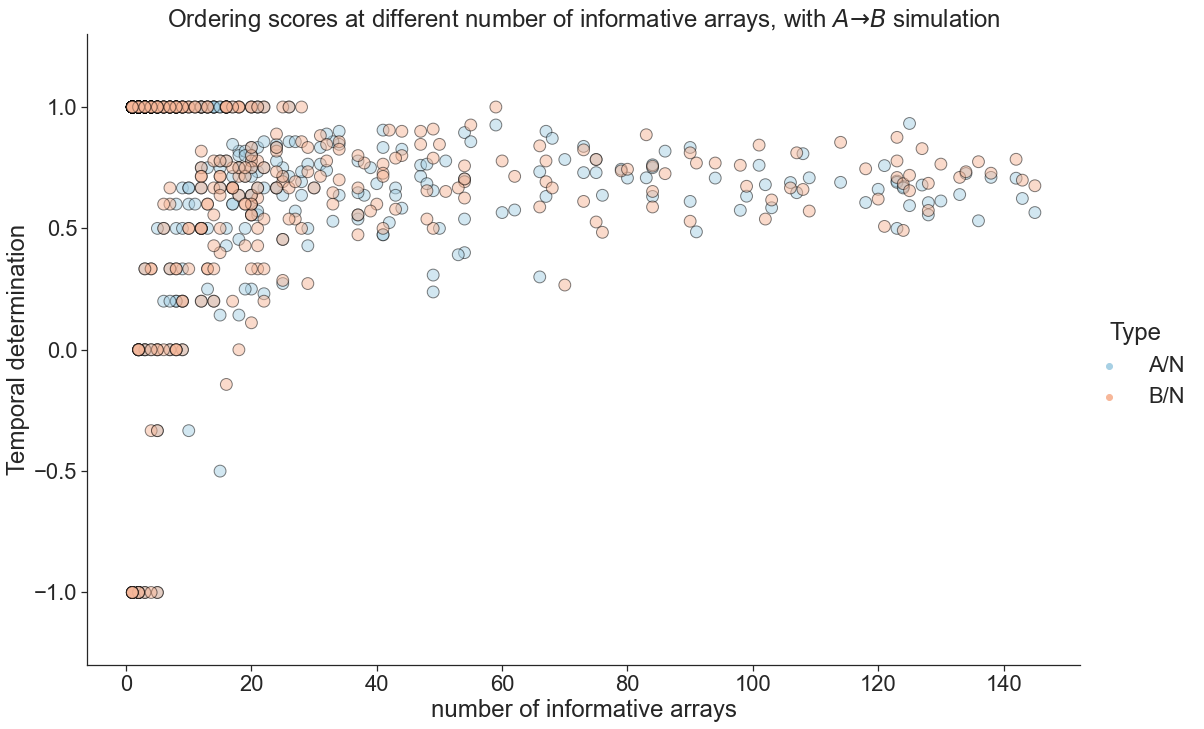

In [756]:
small_summarized_df_plt = small_summarized_df[small_summarized_df["Type"]!="A/B"]

sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.relplot(x="n_informative_arrays", y="Score", hue = "Type", #hue_order =  ["A/N", "B/N", "A/B"], 
        data= small_summarized_df_plt, height=10.27, aspect=12.7/8.27, edgecolor='black',  linewidth=1, s=140, alpha = 0.5,# 
                palette= c_palette)

plt.ylim(-1.3, 1.3)


g.set(xlabel='number of informative arrays', ylabel='Temporal determination', title=r"Ordering scores at different number of informative arrays, with $A \to B$ simulation")

g.savefig("temporal_AB_determination_informative_arrays_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

## Plot percentage of NaN scores vs. informative arrays

In [760]:
df_count_nans = summarized_df_na0[["n_informative_arrays", "Score"]].value_counts().reset_index().rename(columns={0:"count"}).sort_values('n_informative_arrays')
series_count_nans = df_count_nans.groupby(["n_informative_arrays", "Score", ]).sum()["count"]
ind = list(series_count_nans.index.levels[0])

inf_arr_dict = {}
for i in ind:
    try:
        inf_arr_dict[i] = series_count_nans[i]["NaN"] * 100 / (series_count_nans[i].sum())
    except:
        inf_arr_dict[i] = 0

In [758]:
print (inf_arr_dict)

{0: 100.0, 1: 66.66666666666667, 2: 45.39007092198582, 3: 43.05555555555556, 4: 35.8974358974359, 5: 26.666666666666668, 6: 22.22222222222222, 7: 29.166666666666668, 8: 30.303030303030305, 9: 14.285714285714286, 10: 33.333333333333336, 11: 16.666666666666668, 12: 30.0, 13: 27.77777777777778, 14: 27.77777777777778, 15: 28.571428571428573, 16: 28.571428571428573, 17: 11.11111111111111, 18: 23.80952380952381, 19: 13.333333333333334, 20: 20.512820512820515, 21: 28.571428571428573, 22: 26.666666666666668, 24: 33.333333333333336, 25: 26.666666666666668, 26: 22.22222222222222, 27: 33.333333333333336, 28: 0, 29: 11.11111111111111, 30: 33.333333333333336, 31: 16.666666666666668, 32: 16.666666666666668, 33: 0, 34: 22.22222222222222, 37: 25.0, 38: 0, 39: 0, 40: 0, 41: 25.0, 42: 33.333333333333336, 43: 16.666666666666668, 44: 16.666666666666668, 47: 16.666666666666668, 48: 16.666666666666668, 49: 11.11111111111111, 50: 33.333333333333336, 51: 0, 53: 33.333333333333336, 54: 0, 55: 33.33333333333333

In [759]:
n_bins = 30
df_count_nans_plt = pd.DataFrame(inf_arr_dict, index=[0]).T.reset_index().rename(columns = {"index":"n_informative_arrays", 0: "pct_NaN"})
df_count_nans_plt['bins'] = pd.cut(df_count_nans_plt['n_informative_arrays'], n_bins)

df_count_nans_plt

,n_informative_arrays,pct_NaN,bins
0,0,100.000000,"(-0.145, 4.833]"
1,1,66.666667,"(-0.145, 4.833]"
2,2,45.390071,"(-0.145, 4.833]"
3,3,43.055556,"(-0.145, 4.833]"
4,4,35.897436,"(-0.145, 4.833]"
...,...,...,...
89,136,0.000000,"(135.333, 140.167]"
90,138,0.000000,"(135.333, 140.167]"
91,142,0.000000,"(140.167, 145.0]"
92,143,0.000000,"(140.167, 145.0]"


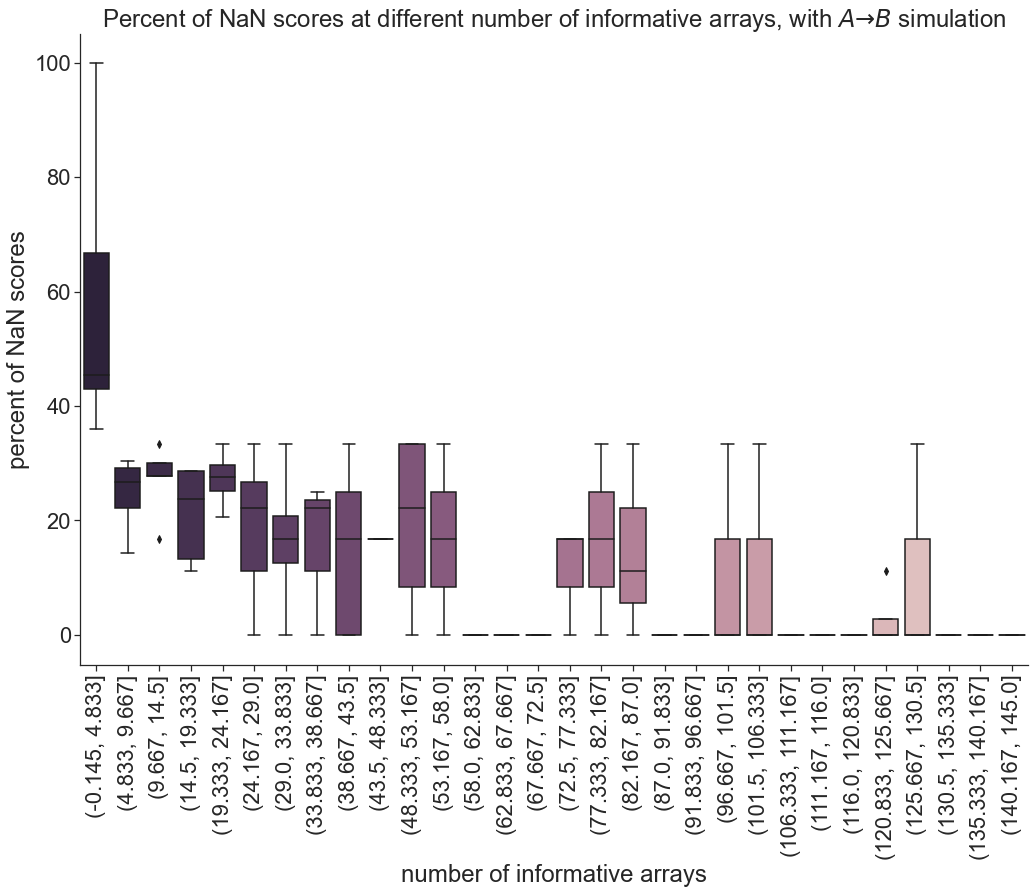

In [752]:
sns.set(font_scale = 2)
sns.set_style("ticks")


g = sns.catplot(x="bins", y="pct_NaN",# hue = "Type", #hue_order =  ["A/N", "B/N", "A/B"], 
        data= df_count_nans_plt, height=10.27, aspect=12.7/8.27, #edgecolor='black',  linewidth=1, #s=100, alpha = 0.5, # 
        #color = "Violet", kind = "box", )
        palette= sns.cubehelix_palette(n_colors = n_bins, reverse=True),  kind = "box")

plt.ylim(-5.3, 105)

plt.xticks(rotation=90)

g.set(xlabel='number of informative arrays', 
      ylabel='percent of NaN scores', 
      title=r"Percent of NaN scores at different number of informative arrays, with $A \to B$ simulation")


g.savefig("pctNaN_informative_arrays_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

### End

---------

Below are other simulations -- feel free to explore them!

#### A+B; B
* **Order of events**: A+B turned on during epoch 1; B turned on during epoch 2
* **Promoter strength**: A and B are near matched
* **Promoter leakiness**: A and B are both reasonably stringent

200'000 arrays generated per PCR indexed and sequenced; 6 PCRs per biological replicate (6 in total)

In [7]:
double_options = [prod for prod in itertools.product('ABN', repeat=2)]

## sbk rates
# rate_A_on = 6.46E-5
# rate_A_off = 1.21E-5
# rate_B_on = 6.47E-5
# rate_B_off = 4.37E-5
# rate_N = 1.41E-3

## good rates
p_A_on = 6.46e-4
p_A_off = 1.21e-4
p_B_on = 6.46e-4
p_B_off = 1.21e-4
p_N = 1.41e-2
n_arrays = 200000

corr_factor = 1

count_dict = {}
double_dict = {}


order = ["AB/B"]
bioreps = ["FQ1", "FQ2", "FQ3", "FQ4", "FQ5", "FQ6"]
pcrs = ["1","2","3","4","5", "6"]

for o in order:
    for rep in bioreps:
        for p in pcrs: 
            file = rep

            double_dict[file] = {}
            triple_dict[file] = {}

            for double in double_options:
                double_dict[file][double] = 0

            for triple in triple_options:
                triple_dict[file][triple] = 0

            double_dict[file]["total reads"] = 0
            double_dict[file]["total expanded"] = 0
            double_dict[file]["A"] = 0
            double_dict[file]["B"] = 0
            double_dict[file]["N"] = 0
            double_dict[file]["Order"] = o
            
            if o == "AB/B":
                ##### gen_arrays(p_A_on, p_A_off, p_B_on, p_B_off, p_N, n_arrays, p)
                ddd = gen_arrays(p_A_on*corr_factor, p_A_off*corr_factor, 
                           p_B_on*corr_factor, p_B_on*corr_factor,
                           p_N*corr_factor, int(np.random.normal(n_arrays/corr_factor, scale = (n_arrays/corr_factor * 0.15))), p)
            
            count_dict[file+"_"+str(p)+"_"+str(o)] = ddd


NameError: name 'triple_dict' is not defined

In [712]:
small_df = pd.DataFrame(count_dict).T.reset_index().rename(columns={"index": "Exact filename"})
small_df["Replicate"] = small_df["Exact filename"].str.split("_", expand=True)[1]
#small_df

In [713]:
small_df_summed_counts["A/N"] = (small_df_summed_counts[('A', 'N')].astype(float)-small_df_summed_counts[('N', 'A')].astype(float))/(small_df_summed_counts[('A', 'N')].astype(float)+small_df_summed_counts[('N', 'A')].astype(float))
small_df_summed_counts["B/N"] = (small_df_summed_counts[('N', 'B')].astype(float)-small_df_summed_counts[('B', 'N')].astype(float))/(small_df_summed_counts[('B', 'N')].astype(float)+small_df_summed_counts[('N', 'B')].astype(float))
small_df_summed_counts["A/B"] = (small_df_summed_counts[('A', 'B')].astype(float)-small_df_summed_counts[('B', 'A')].astype(float))/(small_df_summed_counts[('A', 'B')].astype(float)+small_df_summed_counts[('B', 'A')].astype(float))


df_AN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/N']].rename(columns={'A/N':'Score'}), pd.DataFrame(['A/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_BN = pd.concat([small_df_summed_counts[['Order', "Replicate", 'B/N']].rename(columns={'B/N':'Score'}), pd.DataFrame(['B/N']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
df_AB = pd.concat([small_df_summed_counts[['Order', "Replicate", 'A/B']].rename(columns={'A/B':'Score'}), pd.DataFrame(['A/B']*len(small_df_summed_counts.index), columns=['Type'])], axis=1)
small_summarized_df = pd.concat([df_AN, df_BN, df_AB])
#summarized_df.to_csv("summarized_data_ordering.csv")
display(small_summarized_df)


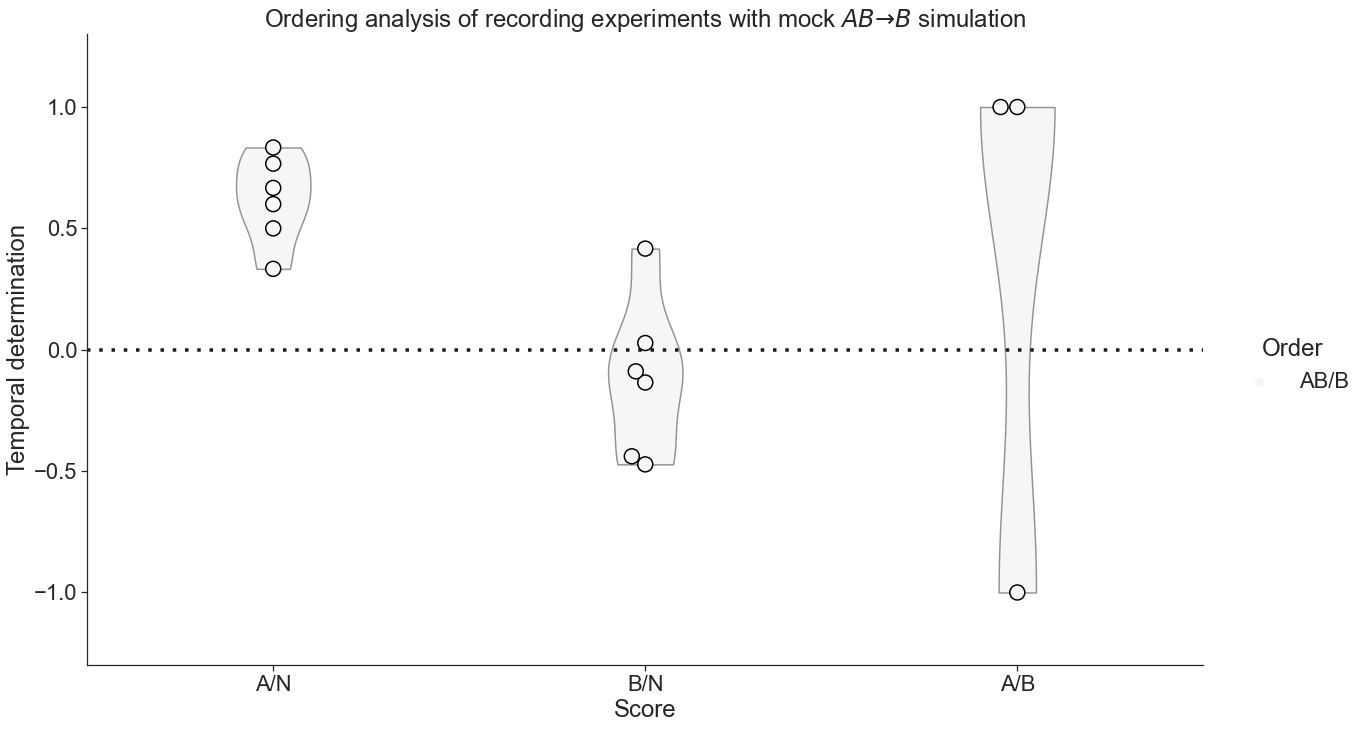

In [714]:
sns.set(font_scale = 2)
sns.set_style("ticks")

c_palette =  "RdBu_r" # "vlag" # "twilight_shifted" # "RdBu_r" #  PuOr_r

g = sns.catplot(x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, kind="swarm", height=10.27, aspect=10.7/6.27, s=15, edgecolor='black', linewidth=1.5,
                palette= c_palette)

g.map(sns.violinplot, x="Type", y="Score", hue = "Order", order = ["A/N", "B/N", "A/B"], 
        data=summarized_df, edgecolor='black', linewidth=1.5, 
        split = False, inner=None, bw=0.5, width =0.2, cut=0,
        dodge=False, alpha = 0.1,
        palette = c_palette,)

plt.ylim(-1.3, 1.3)

g.map(plt.axhline, y=0, ls=(0, (1, 2.5)), c='k', linewidth = 3.5)


g.set(xlabel='Score', ylabel='Temporal determination', title=r"Ordering analysis of recording experiments with mock $AB \to B$ simulation")

g.savefig("ordering_analysis_mock_AB-B_simulation_{0}_{1}_{2}_{3}_{4}.pdf".format(p_A_on, p_A_off, p_B_on, p_B_off, p_N))

---------